In [1]:
import re, gensim, pickle, operator
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_competition = pd.read_csv(data_folder + 'competitors.csv')
df_category = pd.read_csv(data_folder + 'category_groups.csv')
df_investors = pd.read_csv(data_folder + 'investors.csv')

In [3]:
# 각 카테고리에 속하는 회사들의 펀딩 찍어보기
# 회사-카테고리 매핑
df_category = df_organizations[['uuid','category_list']]
print(df_category.head())

                                   uuid  \
0  1e4f199c-363b-451b-a164-f94571075ee5   
1  6681b1b0-0cea-6a4a-820d-60b15793fa66   
2  fd80725f-53fc-7009-9878-aeecf1e9ffbb   
3  10a3b2fd-b142-046b-7d8f-3b1aa4877aca   
4  1d410d6c-13ce-3d53-4e3f-be70dd5ffd54   

                                       category_list  
0  hardware|manufacturing|product design|semicond...  
1                                  hardware|software  
2  cloud computing|collaboration|developer tools|...  
3           hardware|information technology|software  
4               computer|government|service industry  


In [4]:
# 카테고리 리스트를 개별 카테고리로 나눠서 dataframe 으로 만든다
df2 = df_category['category_list'].str.split('|').apply(pd.Series, 1).stack()
df2.index = df2.index.droplevel(-1)
df2.name = 'category_list'
del df_category['category_list']
df_category = df_category.join(df2)
df_category.columns = ['uuid', 'category']
df_category.head()

,uuid,category
0,1e4f199c-363b-451b-a164-f94571075ee5,hardware
0,1e4f199c-363b-451b-a164-f94571075ee5,manufacturing
0,1e4f199c-363b-451b-a164-f94571075ee5,product design
0,1e4f199c-363b-451b-a164-f94571075ee5,semiconductor
1,6681b1b0-0cea-6a4a-820d-60b15793fa66,hardware


In [5]:
# 각 회사의 투자 정보를 불러온다
df_funding = df_funding_rounds[['company_uuid', 'funding_round_uuid', 'announced_on']]
df_funding = df_funding.merge(df_category, left_on = 'company_uuid', right_on = 'uuid', how = 'inner')
df_funding = df_funding.drop('uuid', axis = 1)
df_funding.columns = ['company_uuid', 'funding_round_uuid', 'date', 'category']
df_funding['year-month'] = df_funding['date'].str[:7]
df_funding.head()

,company_uuid,funding_round_uuid,date,category,year-month
0,4f503d57-bf03-4010-6fcc-036fab95b39c,d17ab961-d739-410e-e904-4cb78057cbe1,2017-07-04,financial services,2017-07
1,4f503d57-bf03-4010-6fcc-036fab95b39c,d17ab961-d739-410e-e904-4cb78057cbe1,2017-07-04,fintech,2017-07
2,4f503d57-bf03-4010-6fcc-036fab95b39c,2dd15d97-767c-4eb4-6053-c7a7ce203801,2016-03-15,financial services,2016-03
3,4f503d57-bf03-4010-6fcc-036fab95b39c,2dd15d97-767c-4eb4-6053-c7a7ce203801,2016-03-15,fintech,2016-03
4,bb971d77-d7b8-a3c3-6925-c418077e5d3c,828b3a89-451e-cd0a-6d57-e31dd6a46124,2017-07-04,financial services,2017-07


In [6]:
# 각 회사에 투자한 투자사들의 정보를 합친다
df_investment = pd.DataFrame(df_investments[['funding_round_uuid', 'investor_uuid']].groupby('funding_round_uuid')['investor_uuid'].apply(list)).reset_index()
df_funding = df_funding.merge(df_investment, on = 'funding_round_uuid')
df_funding.head()

,company_uuid,funding_round_uuid,date,category,year-month,investor_uuid
0,4f503d57-bf03-4010-6fcc-036fab95b39c,d17ab961-d739-410e-e904-4cb78057cbe1,2017-07-04,financial services,2017-07,"[1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d..."
1,4f503d57-bf03-4010-6fcc-036fab95b39c,d17ab961-d739-410e-e904-4cb78057cbe1,2017-07-04,fintech,2017-07,"[1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d..."
2,4f503d57-bf03-4010-6fcc-036fab95b39c,2dd15d97-767c-4eb4-6053-c7a7ce203801,2016-03-15,financial services,2016-03,"[307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648..."
3,4f503d57-bf03-4010-6fcc-036fab95b39c,2dd15d97-767c-4eb4-6053-c7a7ce203801,2016-03-15,fintech,2016-03,"[307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648..."
4,bb971d77-d7b8-a3c3-6925-c418077e5d3c,828b3a89-451e-cd0a-6d57-e31dd6a46124,2017-07-04,financial services,2017-07,"[4ede174d-3254-8602-e977-d9c0bfe34433, 94c2fe4..."


In [7]:
# 가장 많이 사용된 탑 10 카테고리
df_category_count = pd.read_csv('../data/others/category_count.csv')
print(df_category_count.head(20))

# # csv 파일이 없을 시 다음의 코드로 저장할 수 있다
# df_funding.groupby('category').size().rename('count').reset_index().sort_values('count', ascending = False).to_csv('../data/others/category_count.csv', index = False)

                  category  count
0                 software  15892
1                   mobile  12275
2              health care  10972
3      enterprise software   9600
4               e-commerce   9173
5                 internet   8314
6            biotechnology   7931
7   information technology   6659
8                     saas   6240
9                analytics   5959
10             advertising   4872
11           manufacturing   4829
12                 medical   4767
13                    apps   4493
14            social media   4357
15               education   3717
16                 finance   3650
17                big data   3482
18                 fintech   3348
19                hardware   3257


In [8]:
# crunchbase 의 카테고리 정보로 빠른 투자자들 찾기
def get_early_investors_by_categories(categories, early_investment_percent = 10, top_k = 30,verbose = True):
    color1 = 'blue'
    if type(categories) == str:
        categories = [categories]

    # 펀딩 정보중 겹치는 데이터를 뺀다
    df = df_funding[df_funding['category'].isin(categories)].drop_duplicates('funding_round_uuid')
    print df.shape
    if df.shape[0] == 0:
        if verbose:
            print 'not found in categories'
        return
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        valid_categories = list(set(list(df_funding['category'].unique())).intersection(set(categories)))
        print('Relevant categories: {}'.format(valid_categories))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [9]:
# company description 에 있는 단어 기반으로 해당 단어에 관련된 회사들에 빨리 투자한 투자자 찾기
def get_early_investors_by_words(words, early_investment_percent = 10, top_k = 30, expand = False, verbose = True):
    color1 = 'blue'
    
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    # 연관 단어도 같이 보고 싶을 시 비슷한 단어를 검색에 포함시킨다
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            if word not in model: continue
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    
    # 해당 단어가 있는 회사들을 모은다
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    # 펀딩 정보중 필요한 회사들만 취하고, 겹치는 데이터를 뺀다
    df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    if df.shape[0] < 10:
        return None
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        print('Keywords: {}'.format(final_words))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:    
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    try:
        df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    except Exception as e:
        print 'none'
        return None
        
        
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:        
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [10]:
def get_early_investors(words, early_investment_percent = 10, top_k = 30):
    get_early_investors_by_categories(words, early_investment_percent = 10, top_k = 30)
    get_early_investors_by_words(words, early_investment_percent = 10, top_k = 30)

In [11]:
# crunchbase 의 카테고리 정보로 빠른 투자자 vs 전체 그려보기
def plot_early_investors(category, weight_scheme = 'sqrt', TOP_K = 30, verbose = True, this_is_word = False, expand = False):
    color1 = 'black'
    color2 = 'blue'
    color3 = 'red'

    # 일단은 centrality top VC 를 그려보자
    central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
    topVC = [uuid for uuid, value in central[:TOP_K]]
    top_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(topVC)]['funding_round_uuid'].unique()
    
    if this_is_word:
        expert = pickle.load(open('../data/others/investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))
    else:
#         expert = pickle.load(open('../data/others/investor_harmonic_rank_for_{}.pickle'.format(category)))
        expert = pickle.load(open('../data/others/investor_{}_harmonic_rank_for_{}.pickle'.format(weight_scheme, category)))
    expert = sorted(expert.items(), key = operator.itemgetter(1))

    expertVC = [uuid for uuid, value in expert[:TOP_K]]
    expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(expertVC)]['funding_round_uuid'].unique()

    if this_is_word:
        if 'word2company' not in globals():
            print('loading word2company')
            global word2company
            word2company = pickle.load(open(util_folder + 'word2company.pickle'))
        if 'model' not in globals():
            print('loading word2vec model')
            global model
            model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

        words = category
        final_words = []
        if type(words) == str:
            words = [words]
        for word in words:
            if ' ' in word:
                word = word.replace(' ', '_')
            if expand:
                if word not in model: continue
                _words = model.most_similar(word)
                _words = [str(_word) for _word, sim in _words]
                final_words.extend(_words)
            final_words.append(word)
        final_words = list(set(final_words))
        print final_words

        # 해당 단어가 있는 회사들을 모은다
        companies = []
        for word in final_words:
            _companies = word2company.get(word, [])
            companies.extend(_companies)
        companies = list(set(companies))

#         if category not in word2company:
#             print 'word', category, 'is not in dataset'
#             return
        df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    else:
        df = df_funding[df_funding['category'] == category].drop_duplicates('funding_round_uuid')
    df_top = df[df['funding_round_uuid'].isin(top_funding_round_uuids)]
    df_expert = df[df['funding_round_uuid'].isin(expert_funding_round_uuids)]

    print "Category:",category
    print '# investment by all VC', df.shape[0]
    print '# investment by top VC', df_top.shape[0]
    print '# investment by expert VC', df_expert.shape[0]
    if verbose:
        for vc in expertVC[:TOP_K]:
            print df_investors[df_investors['uuid'] == (vc)]['investor_name'].values[0]
    try:
        start_year = min(df['year-month'].values)[:4]
    except Exception as e:
        print 'no data'
        return
    count = df.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count').reset_index()
    count_top = df_top.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_top').reset_index()
    count_expert = df_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_expert').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.merge(count_top, on = 'year-month', how = 'left')
    count = count.merge(count_expert, on = 'year-month', how = 'left')

    count = count.sort_values('year-month')
    count = count.fillna(0)

    count['cum_count'] = count['count'].cumsum()
    count['cum_count'] = count['cum_count'] / max(count['cum_count'])

    count['cum_count_top'] = count['count_top'].cumsum()
    count['cum_count_top'] = count['cum_count_top'] / max(count['cum_count_top'])

    count['cum_count_expert'] = count['count_expert'].cumsum()
    count['cum_count_expert'] = count['cum_count_expert'] / max(count['cum_count_expert'])
    
    count[['year-month', 'cum_count', 'cum_count_top', 'cum_count_expert']].plot(x = count['year'], linestyle = '-', color = [color1, color2, color3], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['total', 'centrality', 'early'])
    plt.show()

In [12]:
save = False
begin_from = 1000 # 처음부터 학습하고 싶으면 0 으로 설정

if save:
    category_weight = df_category_count.set_index('category')['count'].to_dict()
    category2investor = pickle.load(open('../data/others/category2investor.pickle'))

    weight_schemes = ['log', 'sqrt', 'simple']
    for weight_scheme in weight_schemes:
        for index, _category in enumerate(df_category_count['category']):
            if index < begin_from: continue
            score = {}
            for category, investors in category2investor.items():
                if category == _category: continue
                for investor in investors:
                    score[investor] = 0
            all_investors = score.keys()
            num_max = len(all_investors)

            print 'target category', _category, index, len(category2investor.keys())
            weight_sum = 0
            for category, investors in category2investor.items():
                if category == _category: continue
                if weight_scheme == 'simple': weight_sum += 1
                if weight_scheme == 'sqrt': weight_sum += np.sqrt(category_weight[category])
                if weight_scheme == 'log': weight_sum += np.log(category_weight[category])

                default_rank = (num_max + len(investors)) / 2.0
                default_rank = 1.0 / default_rank

                for rank, investor in enumerate(investors):
                    rank = 1.0 / (rank + 1)
                    if weight_scheme == 'simple': score[investor] += rank
                    if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * rank)
                    if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * rank)

                for investor in all_investors:
                    if investor not in investors:
                        if weight_scheme == 'simple': score[investor] += default_rank
                        if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * default_rank)
                        if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * default_rank)

            for investor in all_investors:
                score[investor] = weight_sum / score[investor]

            try:
                with open('../data/others/investor_{}_harmonic_rank_for_{}.pickle'.format(weight_scheme, _category), 'w') as f:
                    pickle.dump(score, f)
            except Exception as e:
                print e

In [13]:
# 단어가 주어졌을때 연관 단어를 배출하는 helper function
def related_words(words):
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
        
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if word not in model: continue
        _words = model.most_similar(word)
        _words = [str(_word) for _word, sim in _words if _word not in words]
        final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    print final_words
    return final_words

In [14]:
# 모든 카테고리에 대해서 빠른 회사들 찾아서 저장
# 모든 단어에 대해서 빠른 회사들 찾아서 저장
category_min = 10
word_min = 10
save_category = False
save_word = False

if save_category:
    df_category_count = pd.read_csv('../data/others/category_count.csv')
    category2investor = {}
    investor2category = {}

    df_category_count = df_category_count[df_category_count['count'] >= category_min]
    categories = df_category_count['category'].values
    for index, category in enumerate(categories):
        if index % (len(categories) // 10) == 0:
            print index, len(categories)
        if type(category) != str: continue
        score = get_early_investors_by_categories(category, early_investment_percent = 10, top_k = 30, verbose = False)

        investors = score['investor_uuid'].values
        category2investor[category] = investors
        for investor in investors:
            if investor not in investor2category:
                investor2category[investor] = []
            investor2category[investor].append(category)
    with open('../data/others/category2investor.pickle', 'w') as f:
        pickle.dump(category2investor, f)
    with open('../data/others/investor2category.pickle', 'w') as f:
        pickle.dump(investor2category, f)

    for category, investors in category2investor.items():
        print category
        print investors
        break
    
if save_word:
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'company2word' not in globals():
        print('loading company2word')
        global company2word
        company2word = pickle.load(open(util_folder + 'company2word.pickle'))

    word2investor = {}
    investor2word = {}

    words = word2company.keys()
    for index, word in enumerate(words):
        if index % (len(words) // 100) == 0:
            print index, len(words)
        if len(word2company[word]) < word_min: continue            
            
        score = get_early_investors_by_words([word], early_investment_percent = 10, top_k = 30, verbose = False)
        if score is None: continue
        investors = score['investor_uuid'].values
        word2investor[word] = investors
        for investor in investors:
            if investor not in investor2word:
                investor2word[investor] = []
            investor2word[investor].append(word)
    with open('../data/others/word2investor.pickle', 'w') as f:
        pickle.dump(word2investor, f)
    with open('../data/others/investor2word.pickle', 'w') as f:
        pickle.dump(investor2word, f)

    for word, investors in word2investor.items():
        print word
        print investors
        break

In [15]:
THRESHOLD = 0.7
TOP_K = 20
# # TOP VC 들에 대해서 그들이 빨리 투자하는 카테고리, 단어 클러스터 찾기
category2investor = pickle.load(open('../data/others/category2investor.pickle'))
investor2category = pickle.load(open('../data/others/investor2category.pickle'))

word2investor = pickle.load(open('../data/others/word2investor.pickle'))
investor2word = pickle.load(open('../data/others/investor2word.pickle'))

# central = pickle.load(open(util_folder + 'investor_centrality_degree.pickle'))
central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
if 'model' not in globals():
    print('loading word2vec model')
    global model
    model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

category_distribution = {}

top20 = [uuid for uuid, value in central[:TOP_K]]
for i, uuid in enumerate(top20):
    print df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], central[i][1]
    categories = investor2category.get(uuid, [])
    words = investor2word.get(uuid, [])
    print "Num Categories:",len(categories), "Num Words:", len(words)
    print categories
    for category in categories:
        category_distribution[category] = category_distribution.get(category, 0) + 1

    word_list = words
    groups = {0 : [word_list[0]]}
    next_index = 1
    for word1 in word_list[1:]:
        found = False
        for index, group in groups.items():
            for word2 in group:
                if model.similarity(word1, word2) > THRESHOLD:
                    found = True
                    _index = index
                    break
            if found:
                break
        if found:
            groups[_index].append(word1)
        else:
            groups[next_index] = [word1]
            next_index += 1
    sorted_groups = sorted(groups.items(), key = lambda i: len(i[1]))
    sorted_groups.reverse()
    for index in range(min(next_index, 15)):
        if len(sorted_groups[index][1]) > 1:
            for word in sorted_groups[index][1]:
                print word,
            print
            print
    print "*"*20
print
category_distribution = sorted(category_distribution.items(), key = lambda x: x[1], reverse = True)
for word, count in category_distribution:
    print word, count, '/' , TOP_K
    

loading word2vec model
SV Angel 0.232518306176
Num Categories: 83 Num Words: 1365
['software', 'mobile', 'e-commerce', 'internet', 'saas', 'analytics', 'advertising', 'apps', 'social media', 'education', 'finance', 'big data', 'fintech', 'financial services', 'cloud computing', 'retail', 'marketplace', 'internet of things', 'mobile apps', 'real estate', 'search engine', 'machine learning', 'artificial intelligence', 'music', 'payments', 'shopping', 'gaming', 'ios', 'sports', 'publishing', 'developer tools', 'edtech', 'online portals', 'recruiting', 'food and beverage', 'events', 'fitness', 'photography', 'marketing automation', 'brand marketing', 'advertising platforms', 'wearables', 'local', 'mobile payments', 'e-learning', 'crowdsourcing', 'social media marketing', 'developer apis', 'data visualization', 'social', 'voip', 'audio', 'personal finance', 'web browsers', 'art', 'accounting', 'e-commerce platforms', 'bitcoin', 'email marketing', 'personal health', 'seo', 'subscription serv

redwood_city menlo_park santa_clara billerica_massachusetts pleasanton_california san_diego sunnyvale_california san_mateo palo_alto mountain_view san_francisco new_york los_angeles seattle hyderabad_india

voip wireless broadband wireless_networks networks ethernet broadband_internet connectivity wi_fi high_speed sonet ip_pbx optical_transport network carrier_grade

desktop web_browser pc tablet smartphone computer mac device tablets handhelds personal_computers android computers mobile_phones mobile_devices

can_easily can are_able lets will would allow may allowing ll helps enable enabling allows

family_offices broker_dealers financial_institutions corporations major_corporations companies banks enterprises businesses firms large_enterprises smes institutions smbs

autoimmune obesity cell_signaling acute chronic_inflammatory characterizing heart_failure diseases modulate cataract_surgery therapies

get give receive find offer obtain provide giving gives getting

organs human_body p

andy alexander aaron zhang edward julie paul jason mason larry nick rui john randy schwartz ben greg michael chen david

bain_capital andreessen_horowitz charles_river organization_sequoia sequoia_capital tenaya_capital norwest_venture khosla_ventures accel_partners dag_ventures venture_capitalist redpoint_ventures innovation_endeavors carmel_ventures sequoia greylock

enables enables_its allow allowing letting helps enables_users enables_individuals enable empowers enabling_them enabling allows

wdm carrier_ethernet carrier_class triple_play ethernet switching fiber_optic converged base_stations ethernet_switch broadband_wireless wireless_communications

video videos pictures_videos content music_videos photos movies streaming music audio pictures

brands retailers manufacturers merchants stores store dealers suppliers merchant wholesalers

iphone_app app smartphone_app ipad_app mobile_app application android_app system android ios

targeted_attacks attacks malware threats zero_day at

wireless broadband wimax wireless_broadband wired_wireless broadband_access cellular telecommunication broadband_networks mobile_wimax lte ethernet switching transceiver connectivity telecom wireless_networking wi_fi high_speed base_stations telecommunications gsm_gprs routers wireless_communications

redwood_city santa_monica san_jose austin_texas emeryville_california richardson_texas mumbai_india boston_mass san_diego sunnyvale_california munich_germany palo_alto guangzhou_china madison_wisconsin paris_france mountain_view san_francisco new_york bangalore_india los_angeles dulles_virginia pittsburgh_pennsylvania dubai_uae

desktop web_browser tablet smartphone smartphones tablet_smartphone touch_screen ipad pc_mac device windows smart_phone ios_android tablets personal_computers mobiles android mobile_device browser ios computers mobile_phones mobile_devices

combines leverages uses utilises by_leveraging leveraging incorporates leverage by_combining utilizes integrates utilizing us

you your someone something

discover discover_new explore

neural_networks deep_learning machine_learning

amazing awesome great

once before

comments comment

simple easy

app mobile_app

app_store google_play

open_api api

therapists doctors

instagram facebook

hubspot sendgrid

can will

********************
Draper Fisher Jurvetson (DFJ) 0.0296543473414
Num Categories: 167 Num Words: 2730
['software', 'mobile', 'health care', 'enterprise software', 'e-commerce', 'internet', 'biotechnology', 'information technology', 'saas', 'analytics', 'advertising', 'manufacturing', 'medical', 'apps', 'social media', 'finance', 'big data', 'fintech', 'hardware', 'financial services', 'medical device', 'security', 'cloud computing', 'video', 'retail', 'telecommunications', 'wireless', 'pharmaceutical', 'electronics', 'marketing', 'marketplace', 'digital media', 'energy', 'health diagnostics', 'internet of things', 'mobile apps', 'real estate', 'search engine', 'semiconductor', 'automotive', 'mac

connects empowers allows

our their

videos photos

audience target_audience

app mobile_app

creating building

beautiful colorful

advanced_analytics machine_learning

collaborate connect

athletes coaches

payment_options payment_methods

country world

track measure

get find

********************

big data 14 / 20
apps 14 / 20
social media 13 / 20
machine learning 13 / 20
mobile apps 13 / 20
fintech 13 / 20
saas 13 / 20
advertising 12 / 20
e-commerce 12 / 20
mobile 12 / 20
fashion 11 / 20
analytics 11 / 20
payments 11 / 20
artificial intelligence 11 / 20
search engine 11 / 20
retail 10 / 20
finance 10 / 20
internet 10 / 20
robotics 10 / 20
ios 10 / 20
software 10 / 20
health care 10 / 20
education 10 / 20
cloud computing 10 / 20
financial services 9 / 20
information technology 9 / 20
sports 9 / 20
travel 9 / 20
gaming 9 / 20
developer apis 9 / 20
fitness 9 / 20
enterprise software 9 / 20
drones 9 / 20
bitcoin 9 / 20
internet of things 9 / 20
collaboration 9 / 20
publishing 9 / 20


(0, 6)
not found in categories
loading word2company
Keywords: ['drone']
Early 10 percent investors before 2014-04-01 
(18 early fundings out of 180 total)
    count                   investor_name     date
0       3                     SK Ventures  2012-11
1       2                  Start-Up Chile  2012-11
2       2                   True Ventures  2012-11
3       2      Oreilly AlphaTech Ventures  2012-11
4       2              ff Venture Capital  2013-05
5       2                     VTF Capital  2013-06
6       1             Andreessen Horowitz  2013-11
7       1                   Foundry Group  2013-09
8       1                       Ooga Labs  2013-09
9       1                     Legend Star  2013-11
10      1               Qualcomm Ventures  2013-05
11      1                   Amino Capital  2013-05
12      1                   SierraMaya360  2013-05
13      1           Alchemist Accelerator  2013-07
14      1                          Nvidia  2008-09
15      1  MVI (MENA Venture 

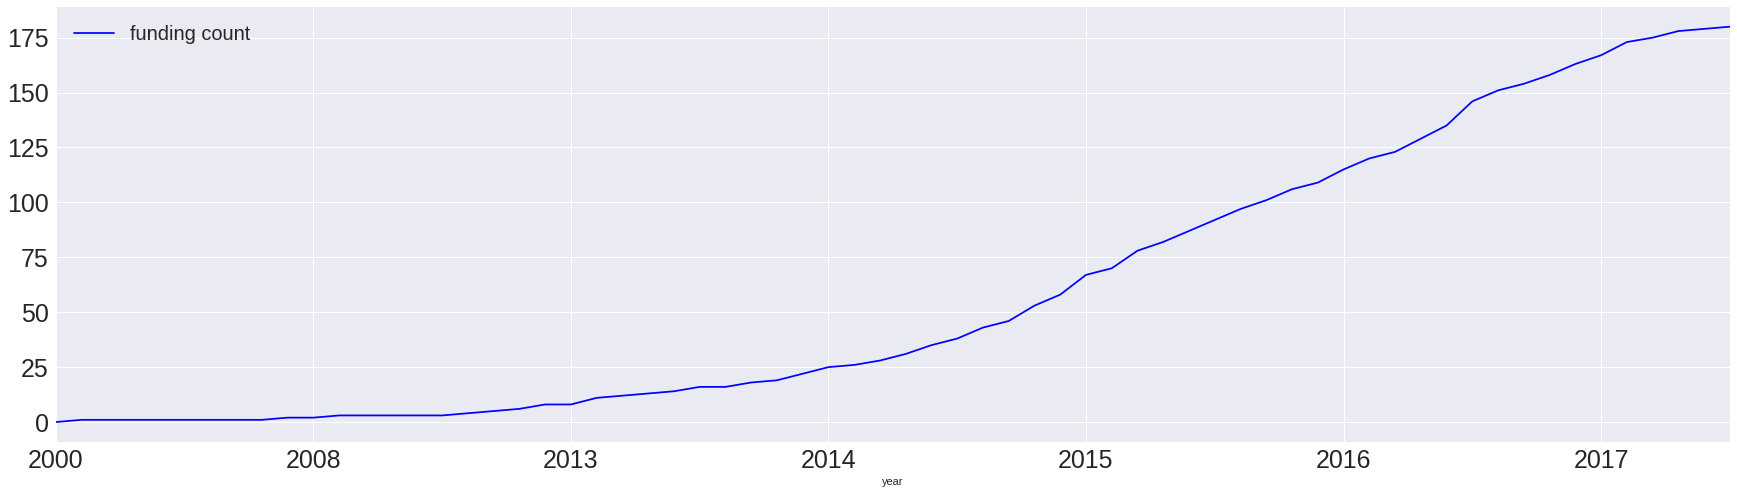

In [16]:
get_early_investors('drone', early_investment_percent = 10, top_k = 30)

(1018, 6)
Relevant categories: ['robotics']
Early 10 percent investors before 2012-04-19 
(101 early fundings out of 1018 total)
    count                     investor_name     date
0       4                          3i Group  2002-04
1       4                       Giant Eagle  2005-07
2       3                   Fenway Partners  2001-10
3       3                Techstars Ventures  2010-10
4       3              RSV Venture Partners  2012-03
5       3               iD Ventures America  2001-10
6       3                  KfW Bankengruppe  2005-05
7       3       National Science Foundation  2010-04
8       3                         Techstars  2010-10
9       3                              SOSV  2011-11
10      3            First Albany Companies  2001-10
11      3                 Bezos Expeditions  2008-08
12      2                     Foundry Group  2010-05
13      2                    Alloy Ventures  2007-08
14      2                  I-Source Gestion  2007-01
15      2              

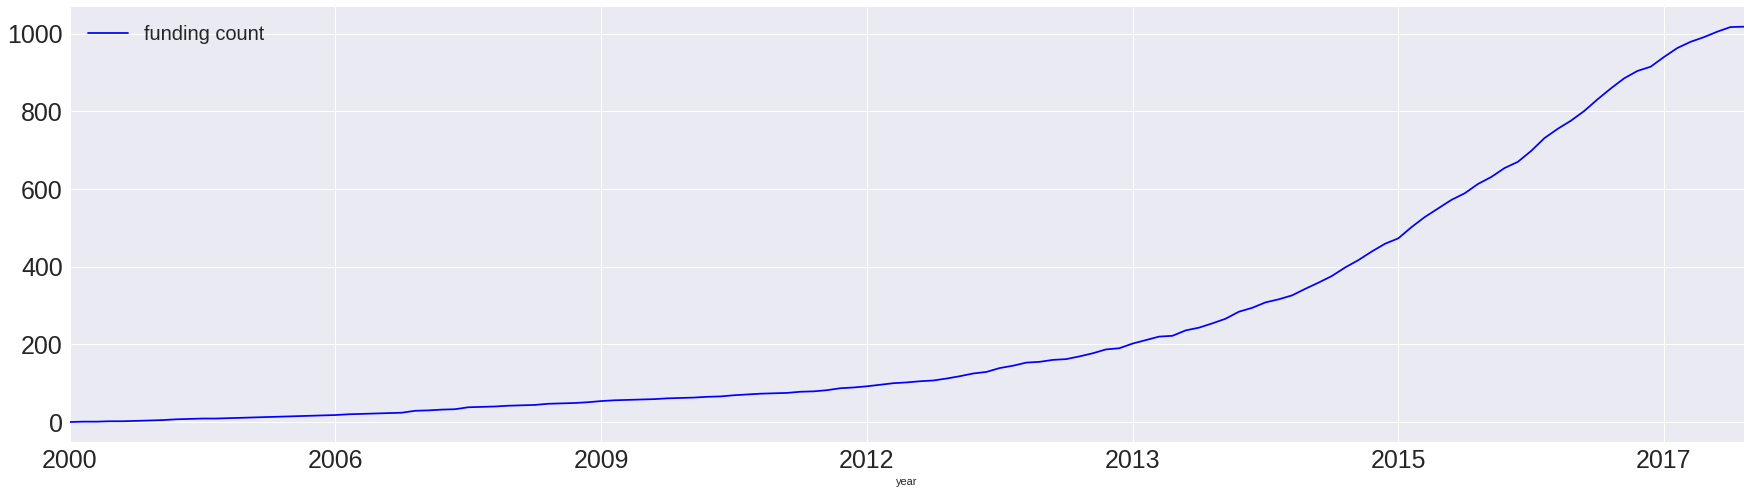

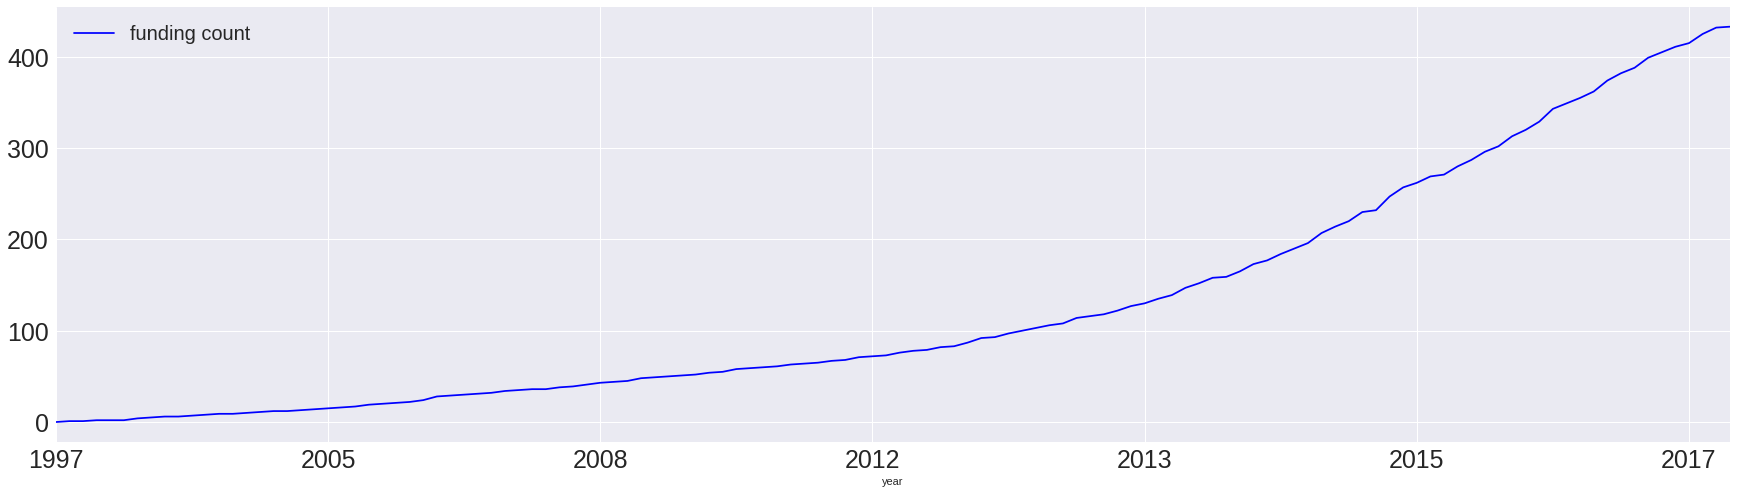

In [17]:
get_early_investors(['robotics'], early_investment_percent = 10, top_k = 30)

In [18]:
related_words(['robotics'])

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']


['synthetic_biology',
 'computer_vision',
 'unmanned_systems',
 'robotics',
 'machine_vision',
 'robots',
 'mechatronic',
 'mechatronics',
 'industrial_robots',
 'robotic',
 'robotic_systems']

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']
(1018, 6)
Relevant categories: ['robotics']
Early 10 percent investors before 2012-04-19 
(101 early fundings out of 1018 total)
    count                     investor_name     date
0       4                          3i Group  2002-04
1       4                       Giant Eagle  2005-07
2       3                   Fenway Partners  2001-10
3       3                Techstars Ventures  2010-10
4       3              RSV Venture Partners  2012-03
5       3               iD Ventures America  2001-10
6       3                  KfW Bankengruppe  2005-05
7       3       National Science Foundation  2010-04
8       3                         Techstars  2010-10
9       3                              SOSV  2011-11
10      3            First Albany Companies  2001-10
11      3                 Bezos Expeditions  2008-08

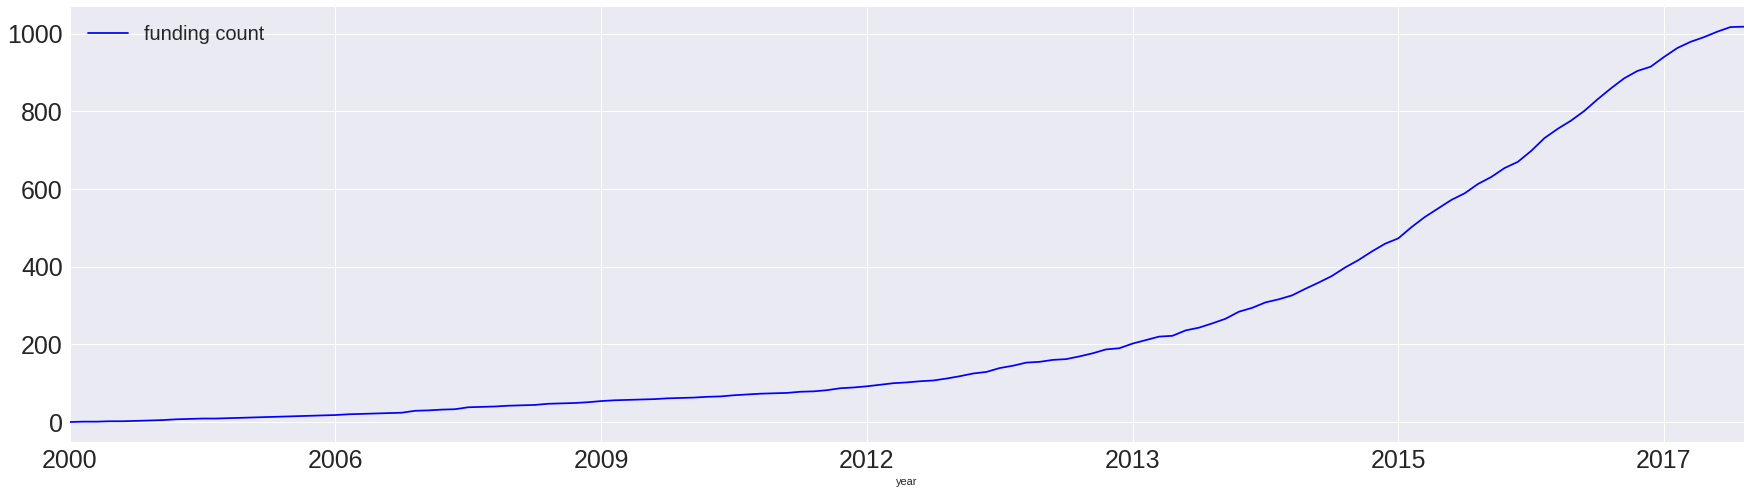

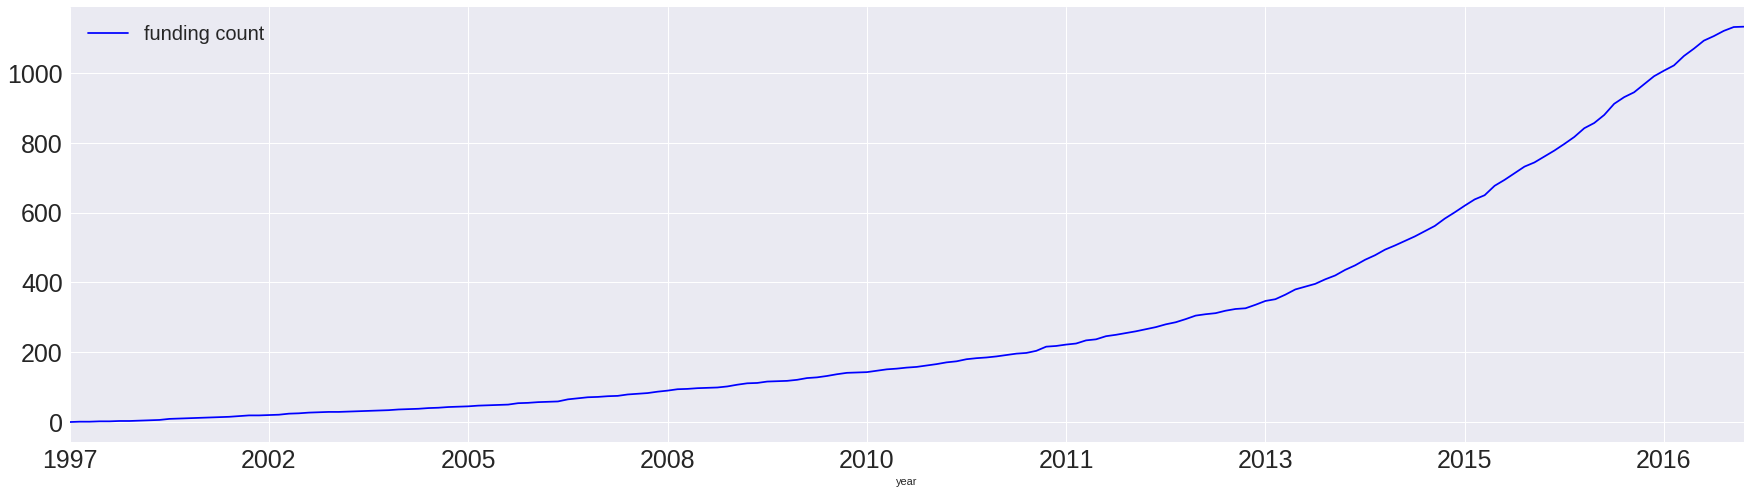

In [19]:
get_early_investors(related_words(['robotics']), early_investment_percent = 10, top_k = 30)

(12275, 6)
Relevant categories: ['mobile']
Early 10 percent investors before 2007-01-01 
(1227 early fundings out of 12275 total)
    count                                  investor_name     date
0      47                                  Intel Capital  1999-03
1      39                                Sequoia Capital  1999-10
2      35                  Draper Fisher Jurvetson (DFJ)  2000-03
3      32                      New Enterprise Associates  1998-03
4      30                                       Redpoint  2000-12
5      27                                       3i Group  2000-09
6      27                      Bessemer Venture Partners  2000-05
7      23                                  Mayfield Fund  2000-03
8      23                                  Apax Partners  2000-11
9      23                   U.S. Venture Partners (USVP)  2000-01
10     22                                 Accel Partners  1996-12
11     20             Motorola Solutions Venture Capital  2003-04
12     19   

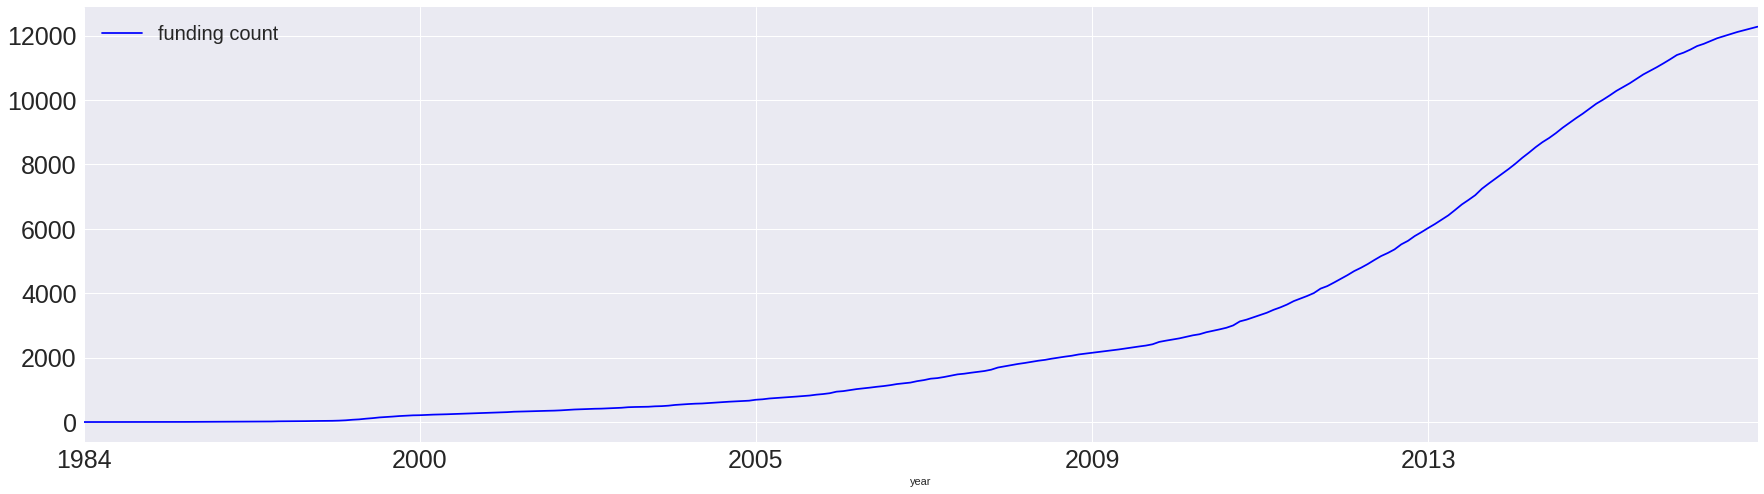

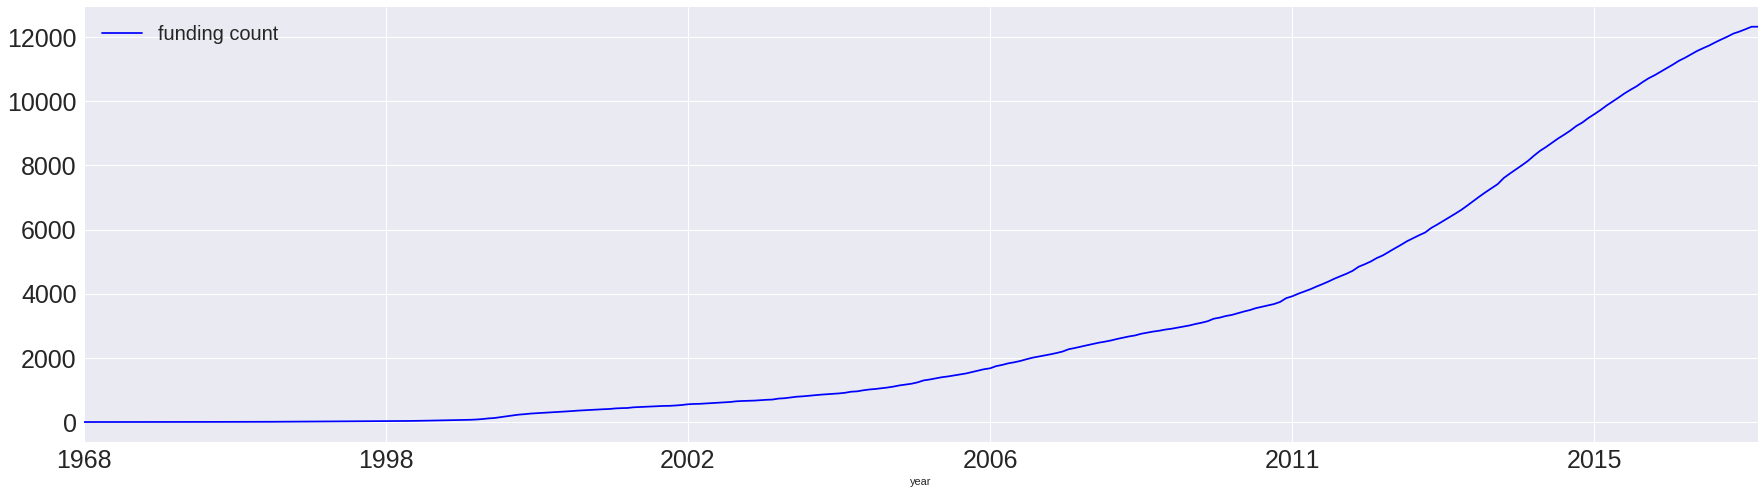

In [20]:
get_early_investors('mobile', early_investment_percent = 10, top_k = 30)

(3348, 6)
Relevant categories: ['fintech']
Early 10 percent investors before 2010-01-26 
(334 early fundings out of 3348 total)
    count                       investor_name     date
0      16                           Techstars  2007-08
1      10                       Intel Capital  2001-10
2       9       Draper Fisher Jurvetson (DFJ)  2003-06
3       9                      Accel Partners  1999-10
4       9                       Goldman Sachs  2000-01
5       9                           Benchmark  2000-08
6       8                   Greylock Partners  2005-05
7       7                     Sequoia Capital  1999-10
8       6           Bessemer Venture Partners  2004-01
9       6      Norwest Venture Partners - NVP  2001-01
10      6               Mohr Davidow Ventures  2000-06
11      6                   Fidelity Ventures  2004-04
12      6                       True Ventures  2006-01
13      6          Advantage Capital Partners  1999-12
14      5                       Icon Ventures  

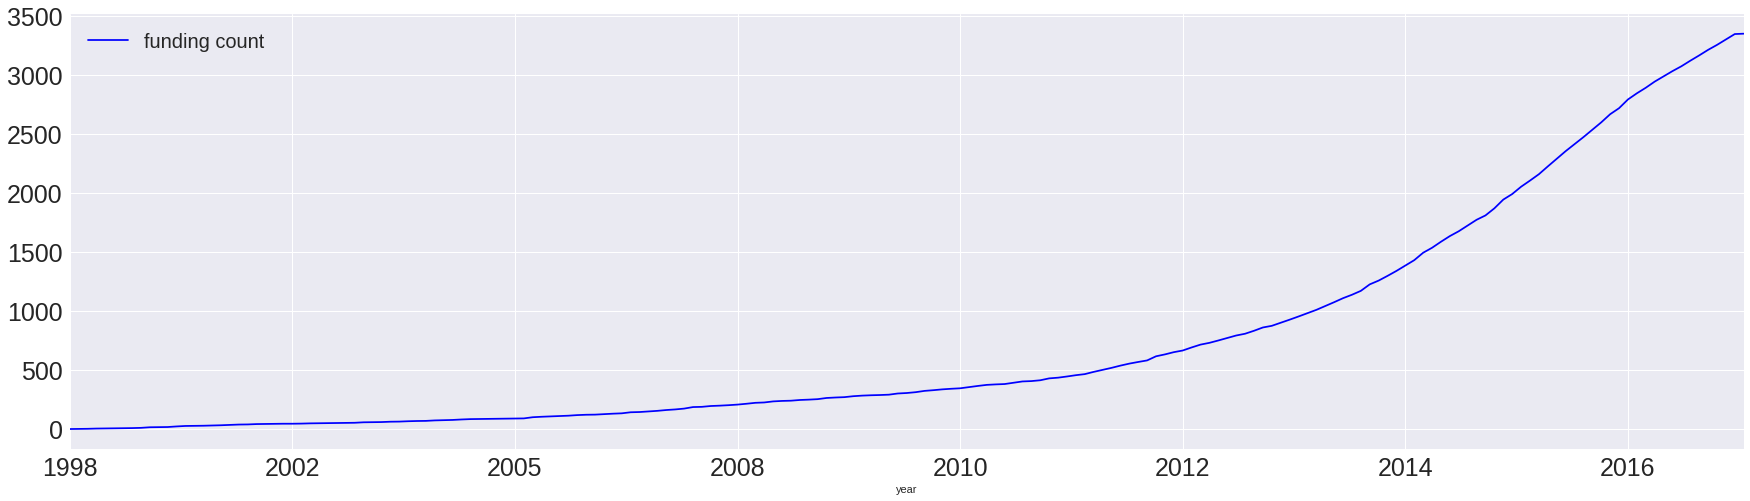

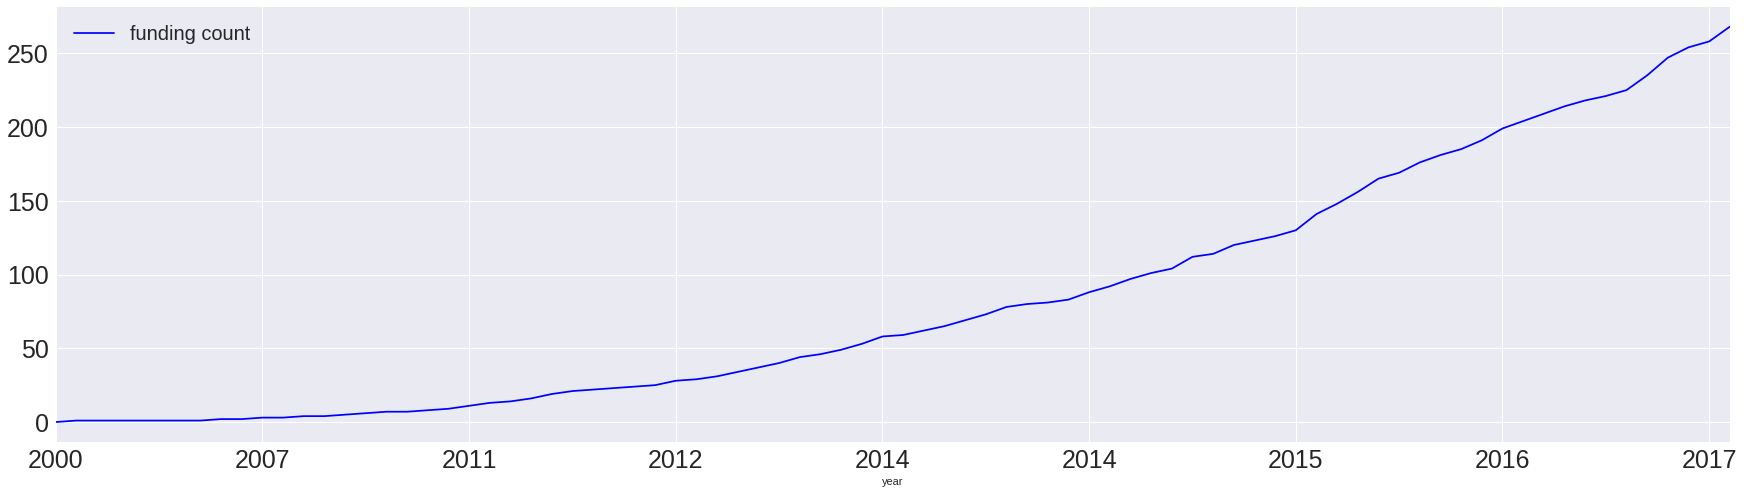

In [21]:
get_early_investors('fintech', early_investment_percent = 10, top_k = 30)

(1542, 6)
Relevant categories: ['artificial intelligence']
Early 10 percent investors before 2012-05-15 
(154 early fundings out of 1542 total)
    count                                      investor_name     date
0       5                                   Cordova Ventures  2002-01
1       5                                      Goldman Sachs  2006-07
2       5                              Mohr Davidow Ventures  2006-11
3       5                                        HIG Capital  2000-09
4       5                                   Felicis Ventures  2006-05
5       5                          Boston Millennia Partners  2002-01
6       4                                 Foundation Capital  2007-04
7       4                                              Wayra  2011-09
8       4                                           SV Angel  2009-07
9       4                                     Accel Partners  2006-11
10      3                                          Capital-E  2008-10
11      3       

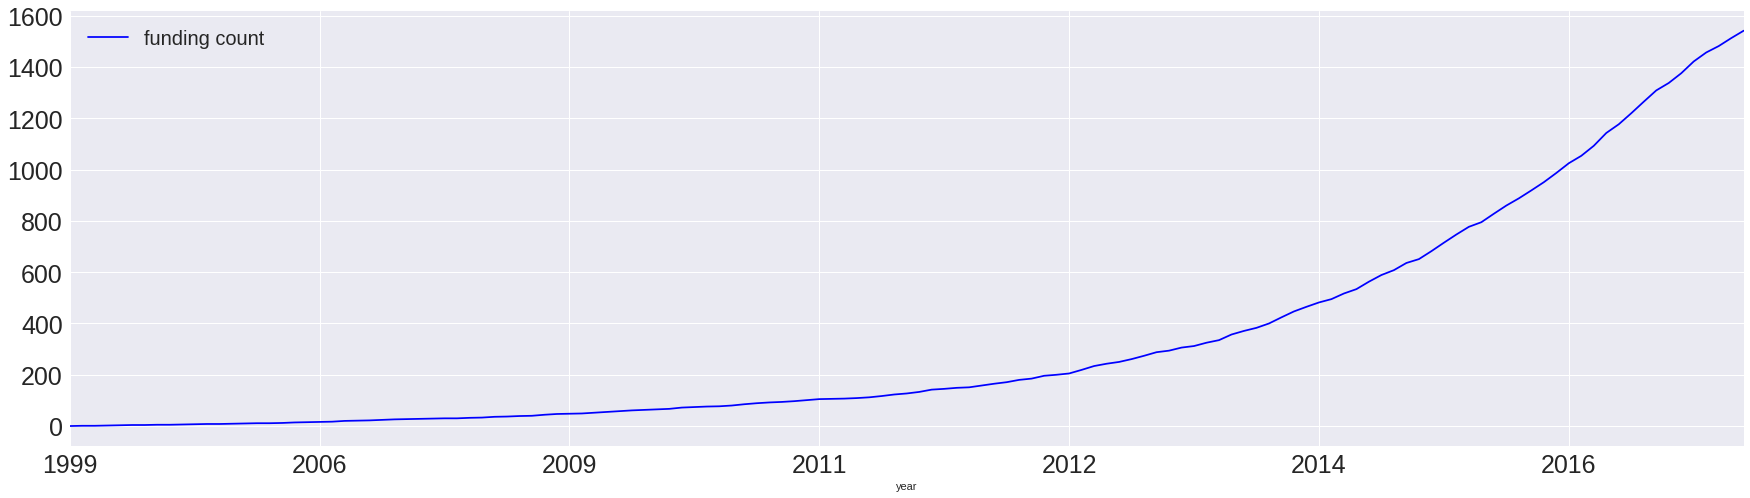

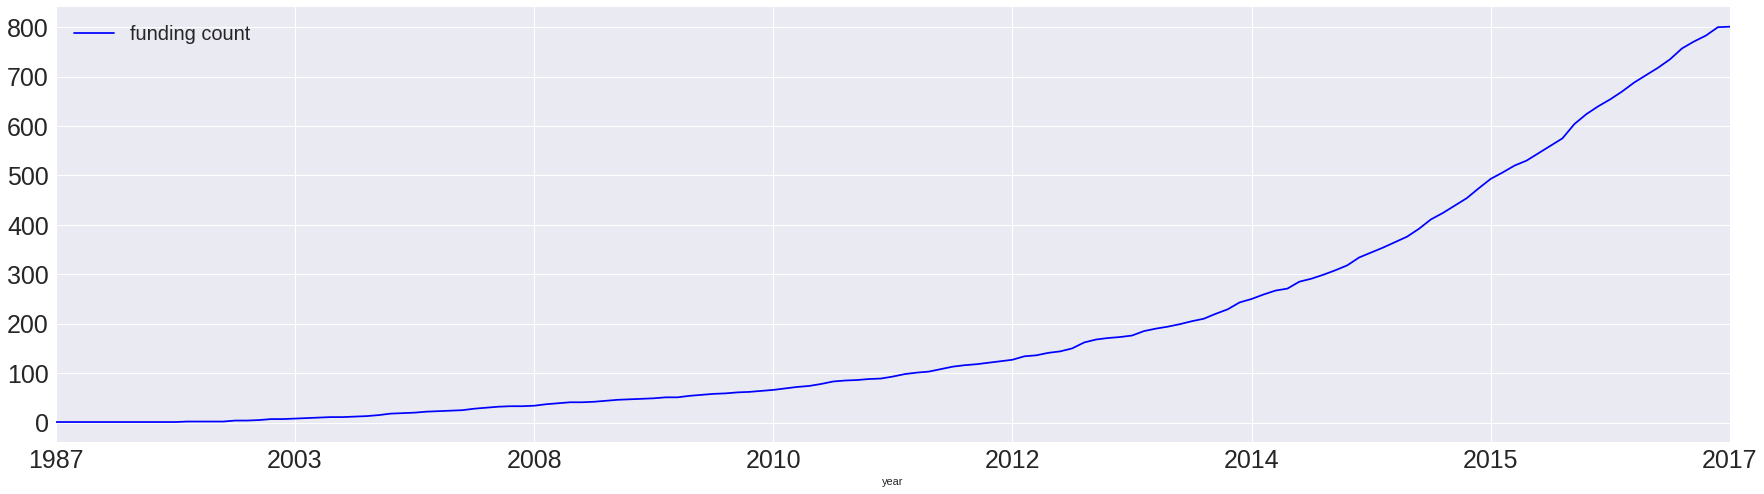

In [22]:
get_early_investors('artificial intelligence', early_investment_percent = 10, top_k = 30)

(900, 6)
Relevant categories: ['consumer']
Early 10 percent investors before 2003-08-01 
(90 early fundings out of 900 total)
    count                         investor_name     date
0       4                         Goldman Sachs  1999-12
1       4                     Flatiron Partners  2000-05
2       4                           TransCosmos  1999-11
3       4                       Summit Partners  1988-11
4       3                                   TCV  1999-12
5       3                       Lehman Brothers  2000-09
6       3                        J & W Seligman  1999-12
7       3                            HM Capital  1999-08
8       3                        Accel Partners  2000-09
9       3         Draper Fisher Jurvetson (DFJ)  2000-04
10      3                              SoftBank  1998-12
11      3                        August Capital  1999-05
12      3             Internet Healthcare Group  2000-07
13      2                        Bowman Capital  1999-12
14      2          

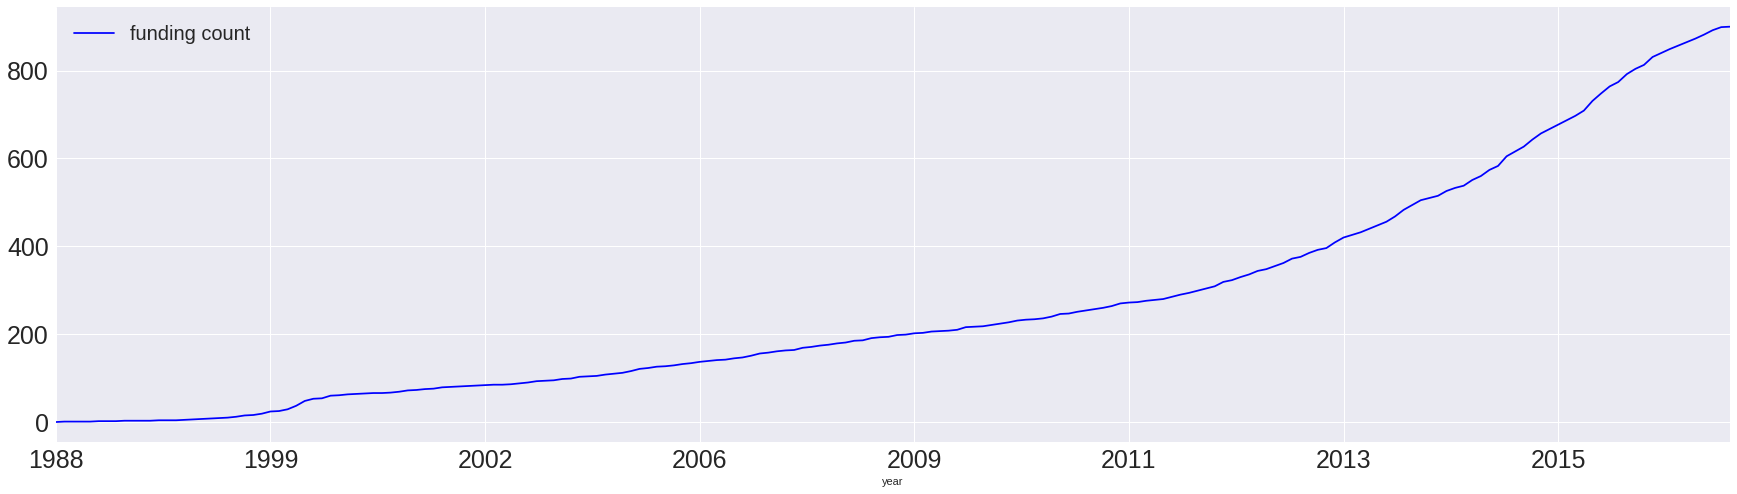

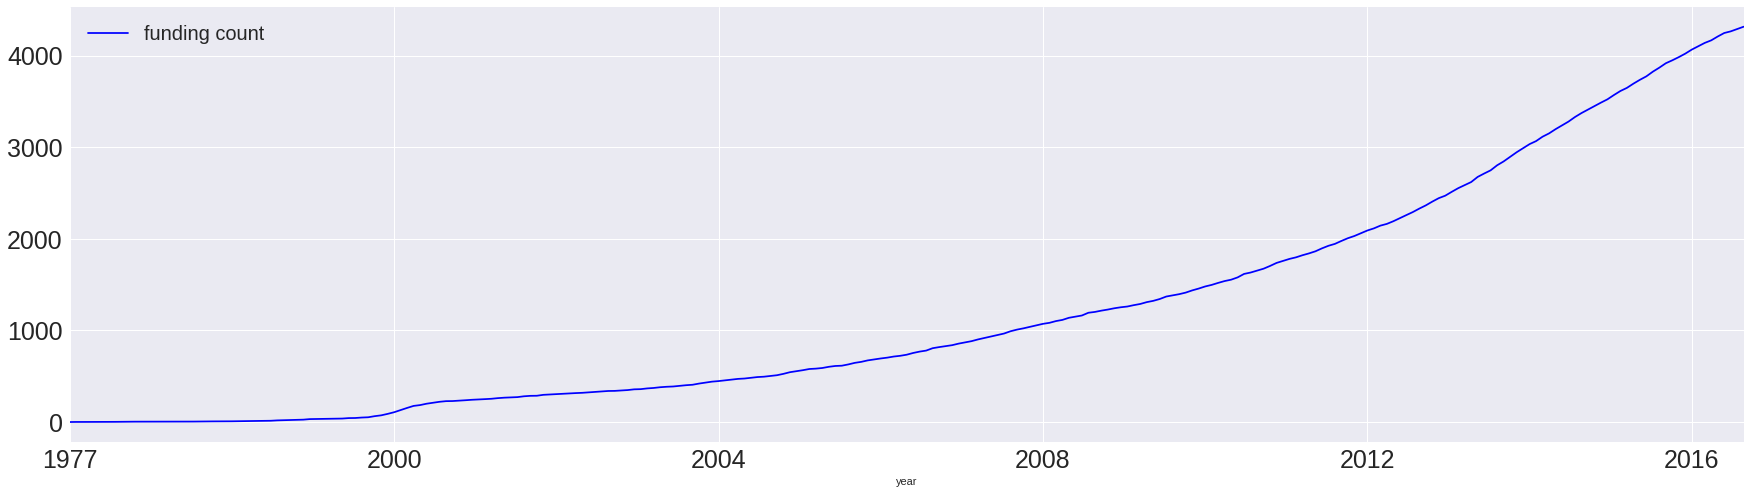

In [23]:
get_early_investors('consumer', early_investment_percent = 10, top_k = 30)

(10972, 6)
Relevant categories: ['health care']
Early 10 percent investors before 2006-02-03 
(1097 early fundings out of 10972 total)
    count                              investor_name     date
0      49                          Domain Associates  1999-02
1      46                  New Enterprise Associates  2000-06
2      44                           Versant Ventures  2000-12
3      32                        Three Arch Partners  2000-03
4      31                                    Venrock  1999-01
5      30  Johnson & Johnson Development Corporation  2000-03
6      29                              Alta Partners  2000-04
7      27                            Summit Partners  1986-05
8      27                                MPM Capital  1999-09
9      26                         InterWest Partners  2000-03
10     26                 Oxford Bioscience Partners  2001-01
11     24                           Polaris Partners  1997-12
12     23                Frazier Healthcare Partners  2000-

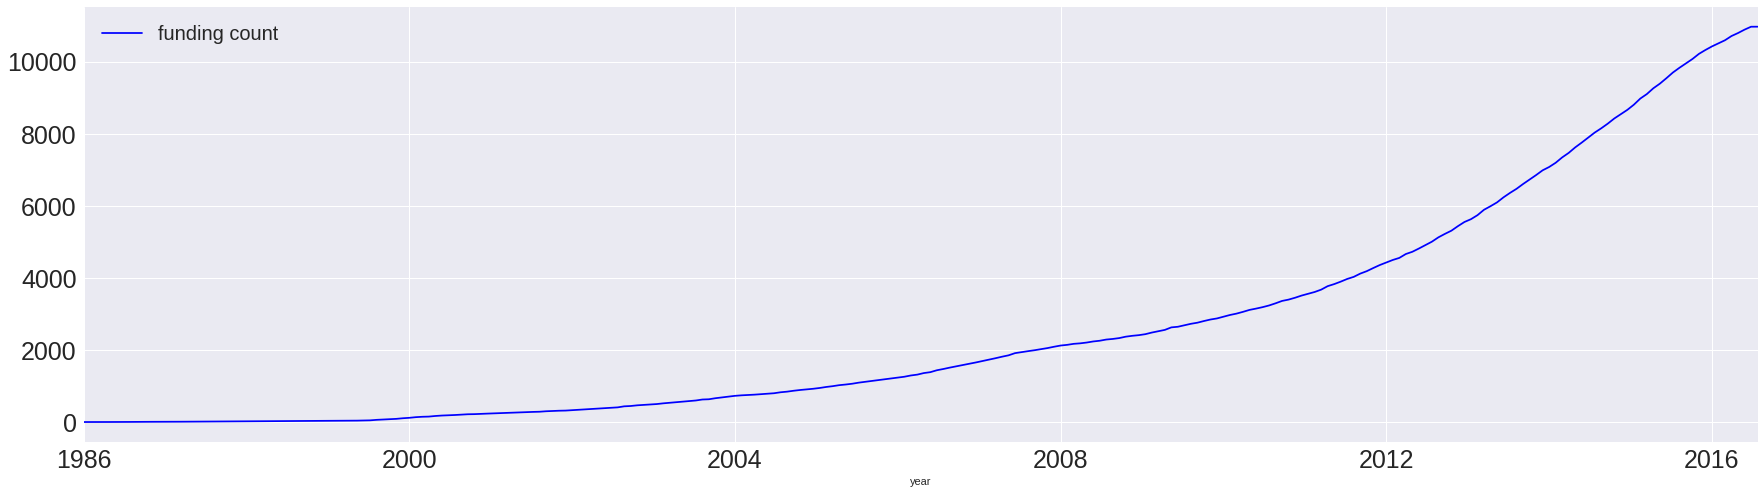

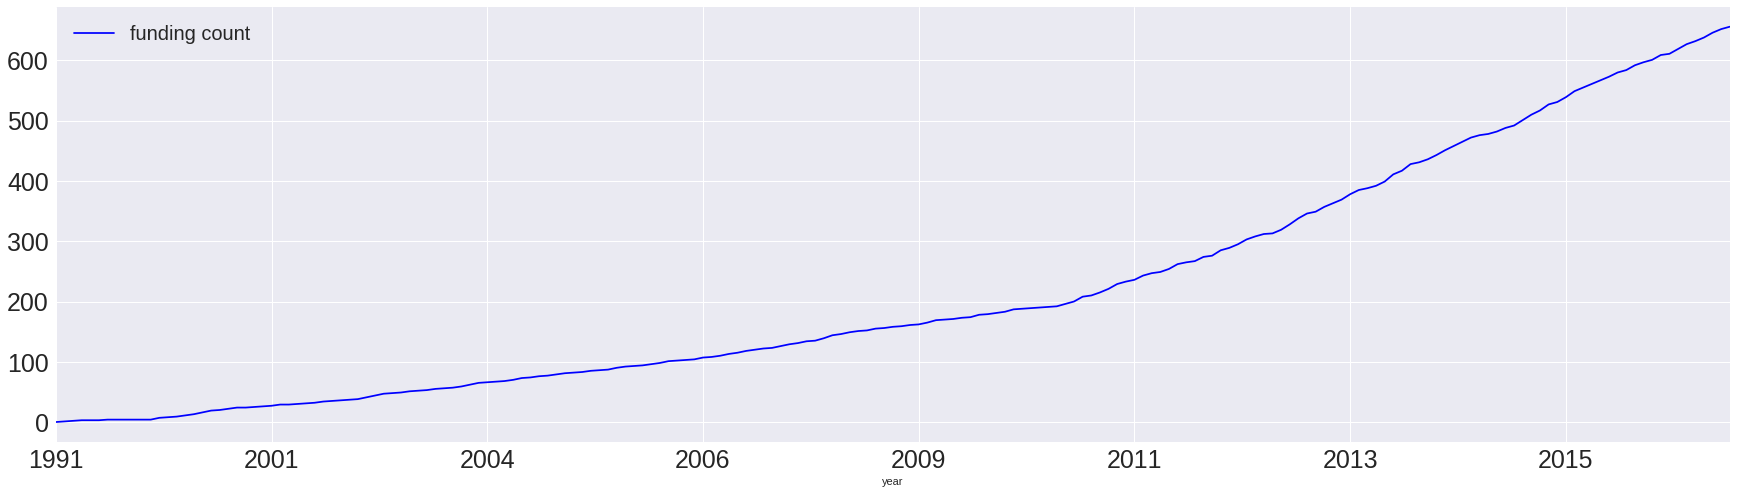

In [24]:
get_early_investors('health care', early_investment_percent = 10, top_k = 30)

(78, 6)
Relevant categories: ['craft beer']
Early 10 percent investors before 2012-10-25 
(7 early fundings out of 78 total)
   count    investor_name     date
0      2        Crowdcube  2011-10
1      1     The Brandery  2011-08
2      1  Leopard Capital  2011-05
3      1      Maxim Godin  2011-10
4      1      PV Ventures  2010-11
5      1   Consor Capital  2006-11
6      1         Rob Keve  2011-10
7      1   Victor Levitin  2011-10
(8, 3)
Keywords: ['craft_beer']
Early 10 percent investors before 2013-03-21 
(2 early fundings out of 28 total)
   count      investor_name     date
0      1         CrunchFund  2012-01
1      1      David Rusenko  2012-01
2      1  Cavallino Capital  2012-04
(3, 3)


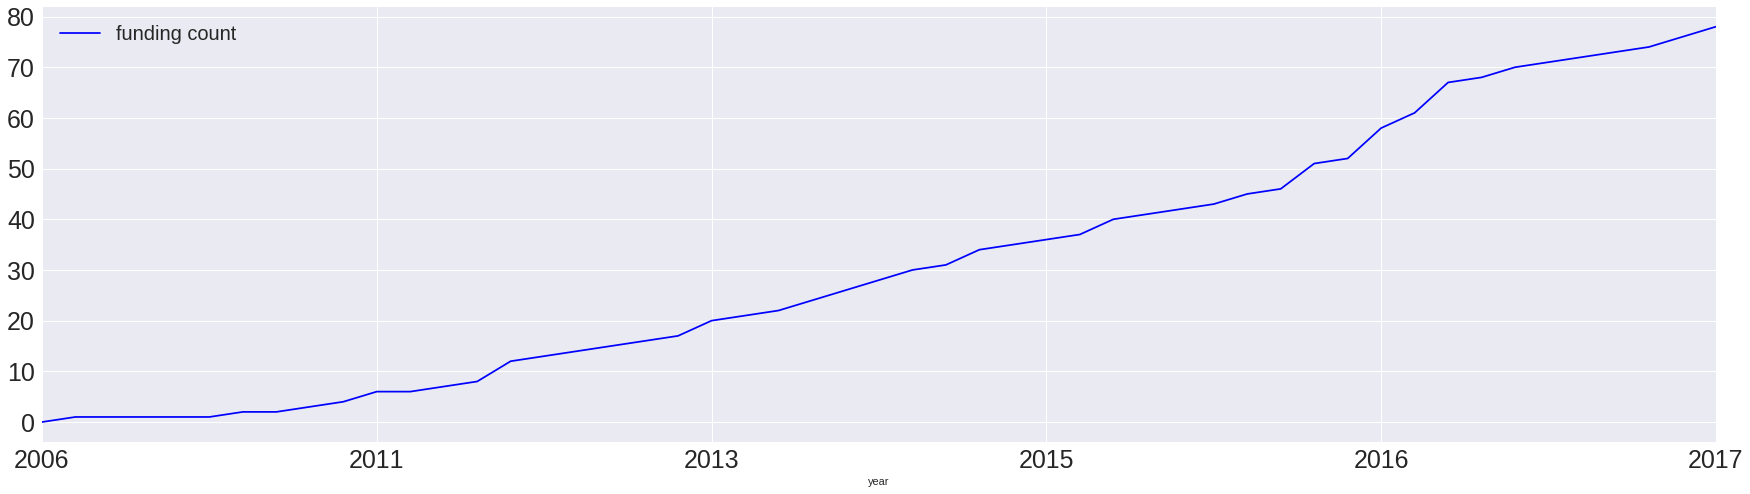

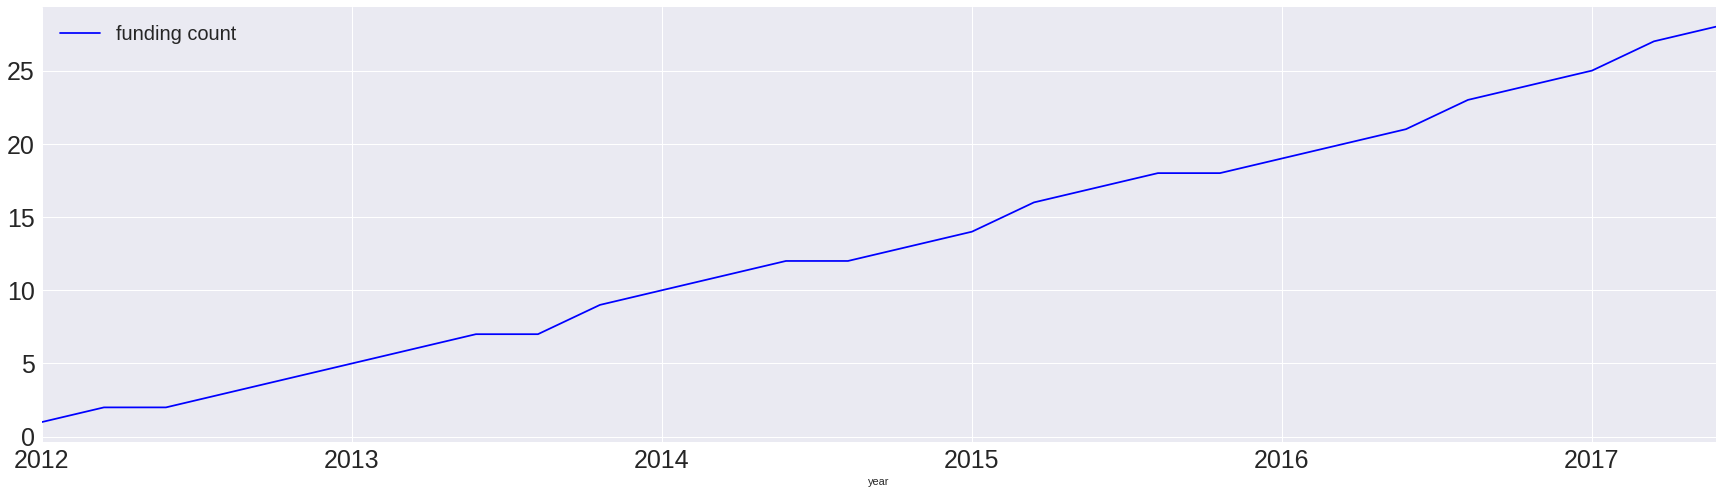

In [25]:
get_early_investors('craft beer', early_investment_percent = 10, top_k = 30)

Category: software
# investment by all VC 15892
# investment by top VC 1405
# investment by expert VC 1254


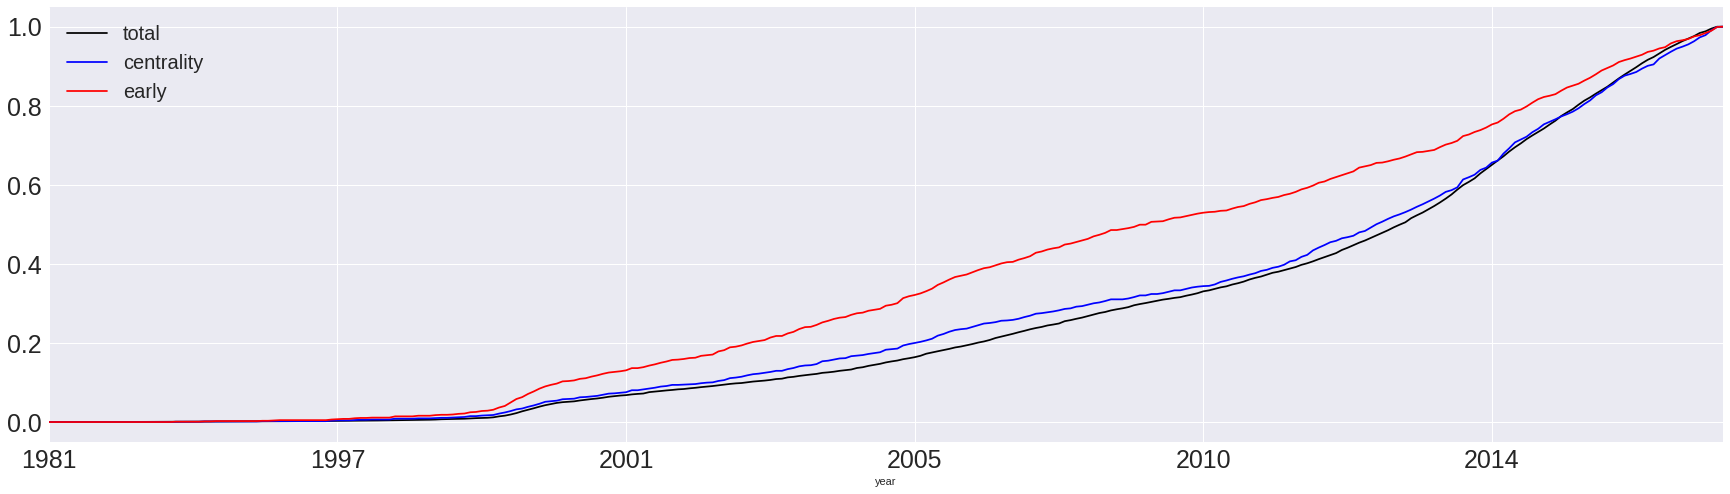

Category: mobile
# investment by all VC 12275
# investment by top VC 1329
# investment by expert VC 945


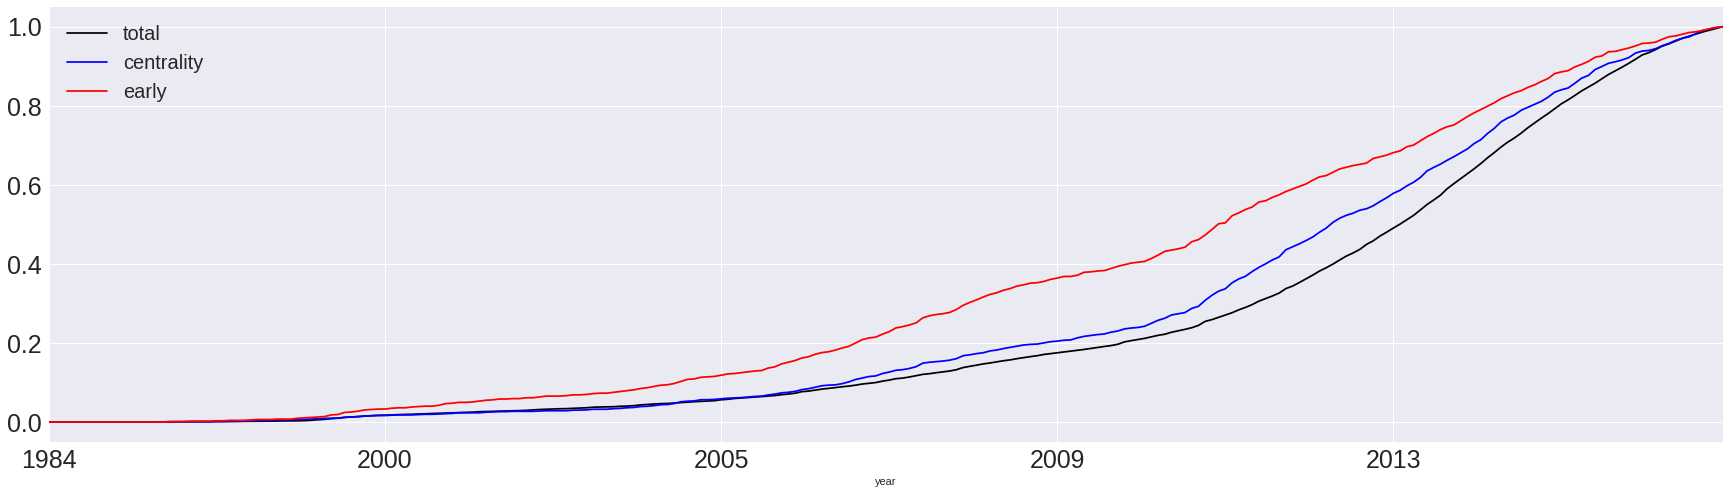

Category: health care
# investment by all VC 10972
# investment by top VC 690
# investment by expert VC 543


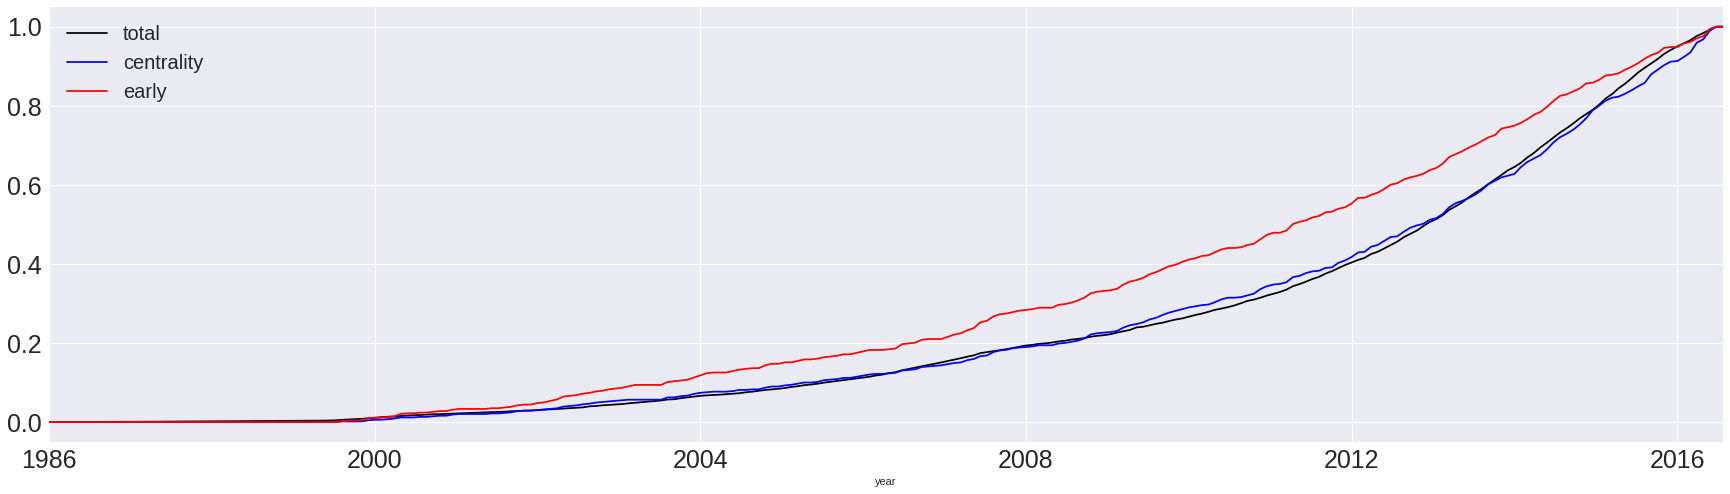

In [26]:
for category in df_category_count['category'].head(3).values:
    plot_early_investors(category = category, weight_scheme = 'log', TOP_K = 10, verbose = False)

['deep_learning']
Category: deep_learning
# investment by all VC 196
# investment by top VC 33
# investment by expert VC 13


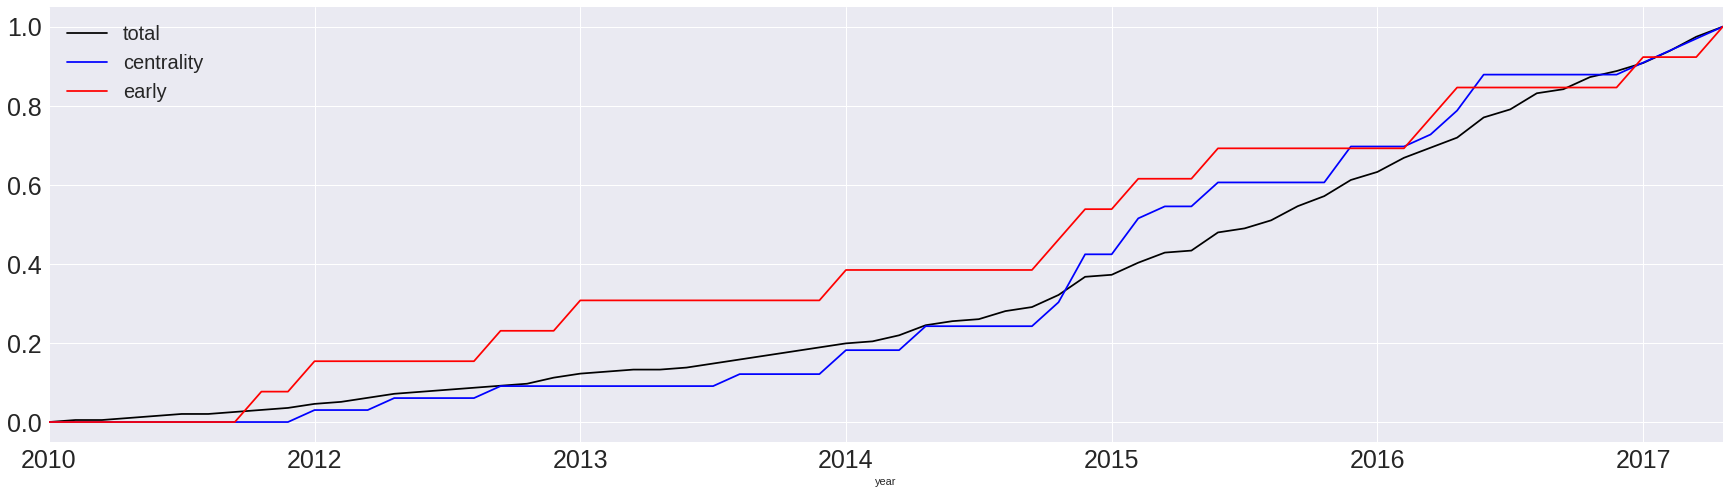

['neural_network', 'computer_vision', 'big_data', 'ai', 'reinforcement_learning', 'cognitive_computing', 'pattern_recognition', 'neural_networks', 'machine_learning', 'artificial_intelligence', 'deep_learning']
Category: deep_learning
# investment by all VC 4162
# investment by top VC 698
# investment by expert VC 527


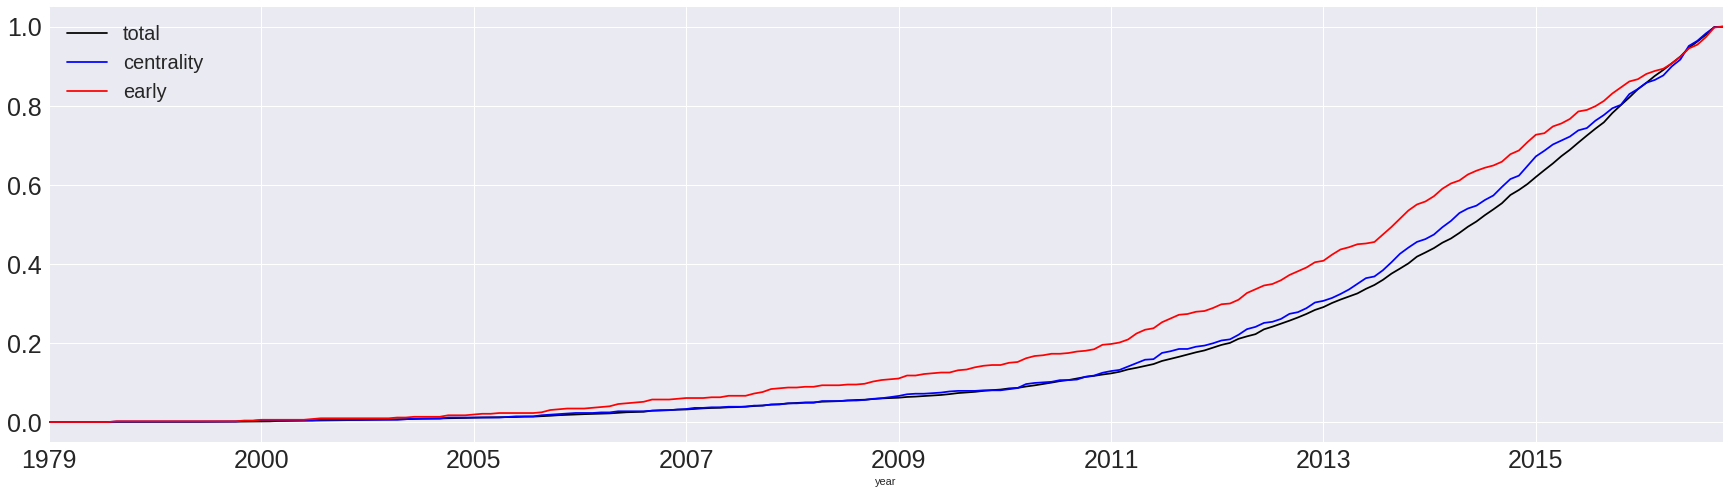

['fintech']
Category: fintech
# investment by all VC 268
# investment by top VC 37
# investment by expert VC 8


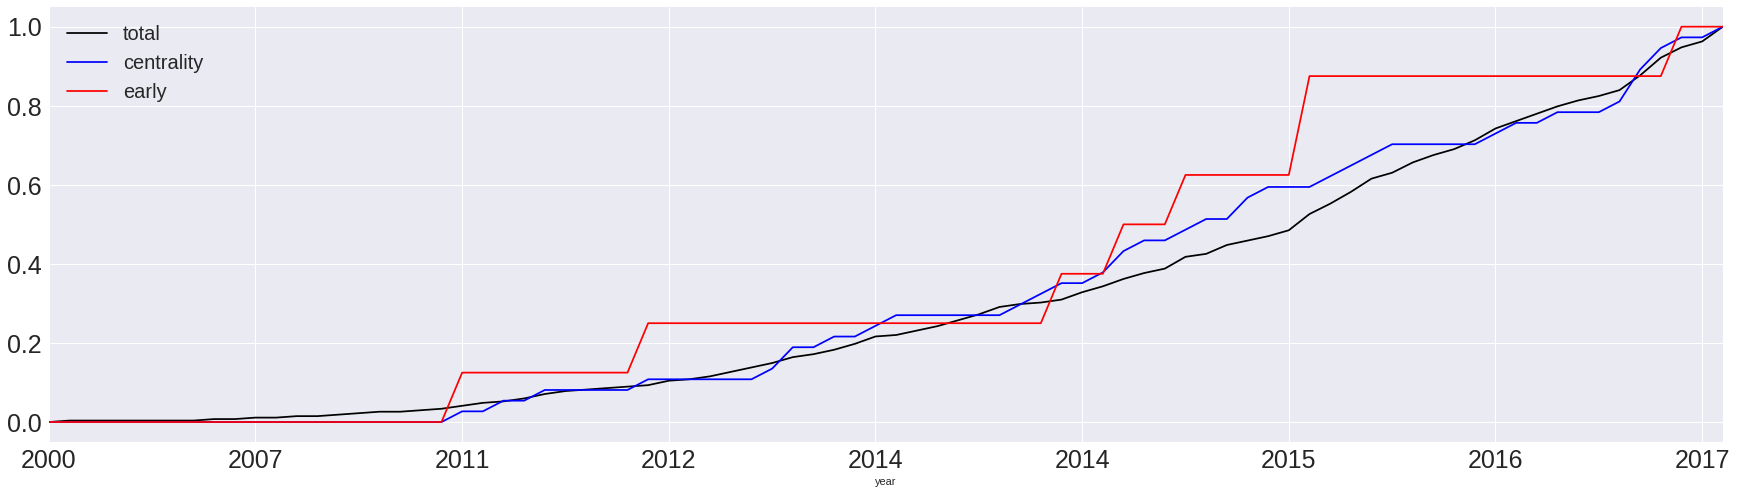

['agtech', 'fintech', 'regtech', 'insurtech', 'edtech', 'cleantech', 'tech', 'fin_tech', 'ad_tech', 'healthtech', 'adtech']
Category: fintech
# investment by all VC 1904
# investment by top VC 257
# investment by expert VC 134


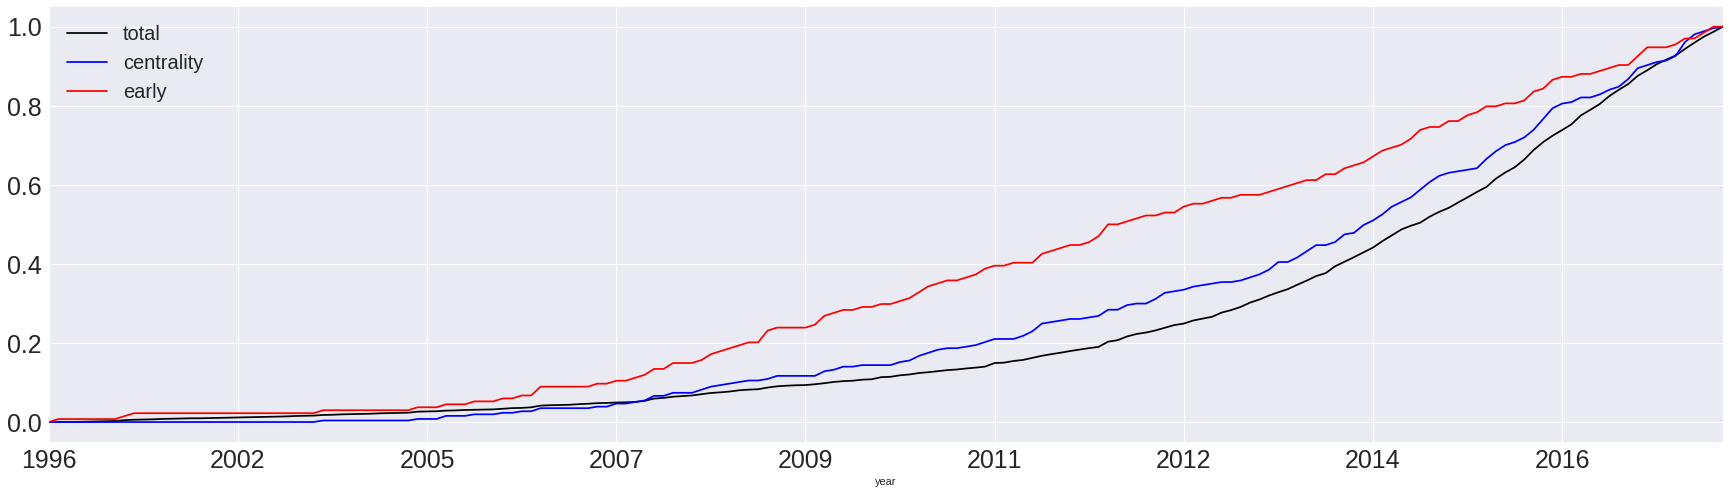

['drone']
Category: drone
# investment by all VC 180
# investment by top VC 31
# investment by expert VC 14


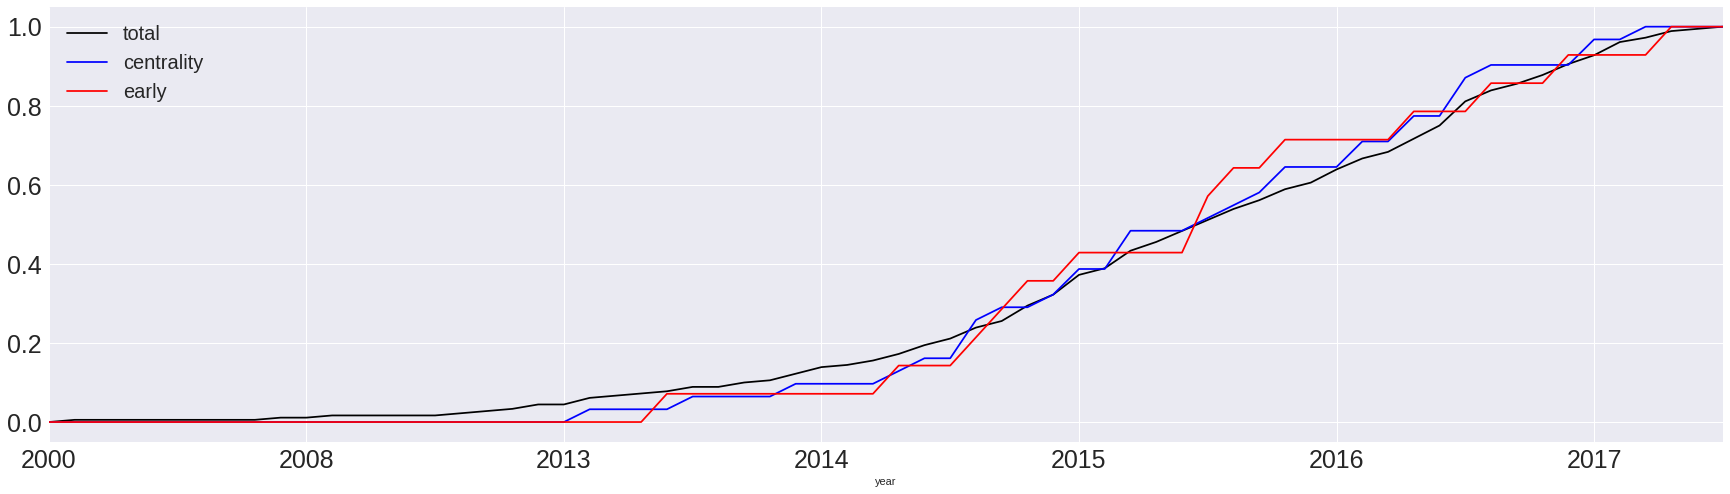

['remotely_operated', 'drone', 'uas', 'unmanned_aerial', 'uav', 'unmanned', 'uavs', 'drones', 'unmanned_aircraft', 'vtol', 'fixed_wing']
Category: drone
# investment by all VC 363
# investment by top VC 63
# investment by expert VC 43


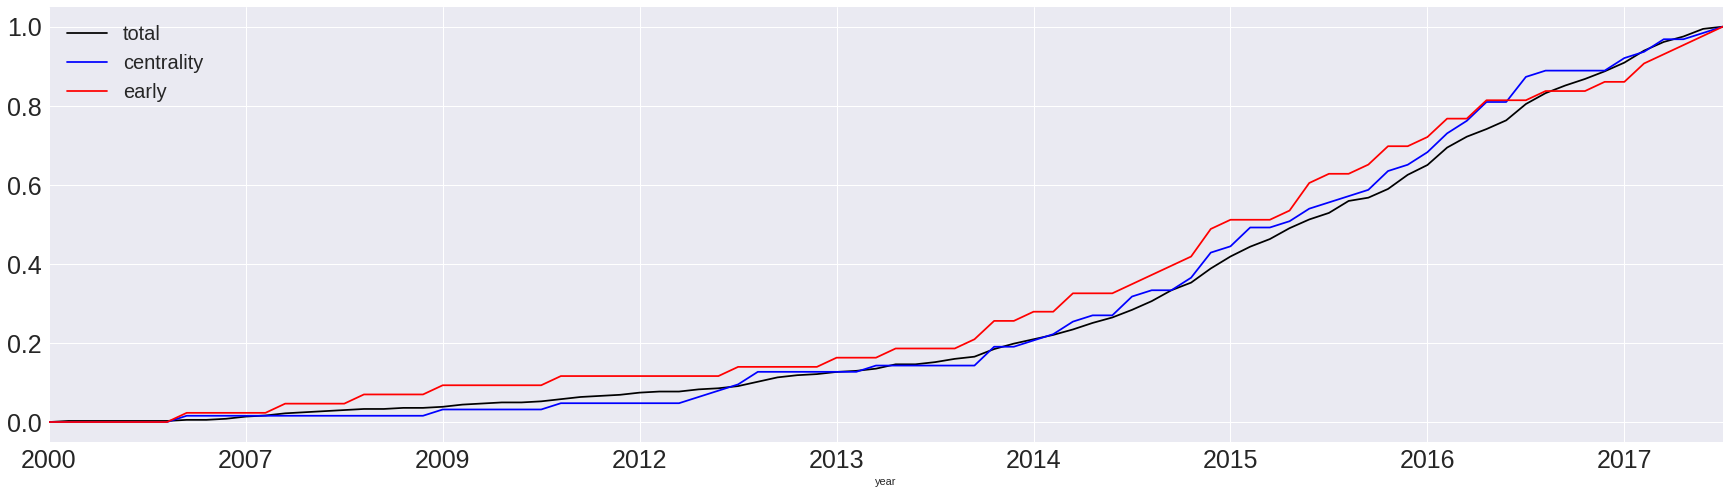

['wearable']
Category: wearable
# investment by all VC 337
# investment by top VC 23
# investment by expert VC 16


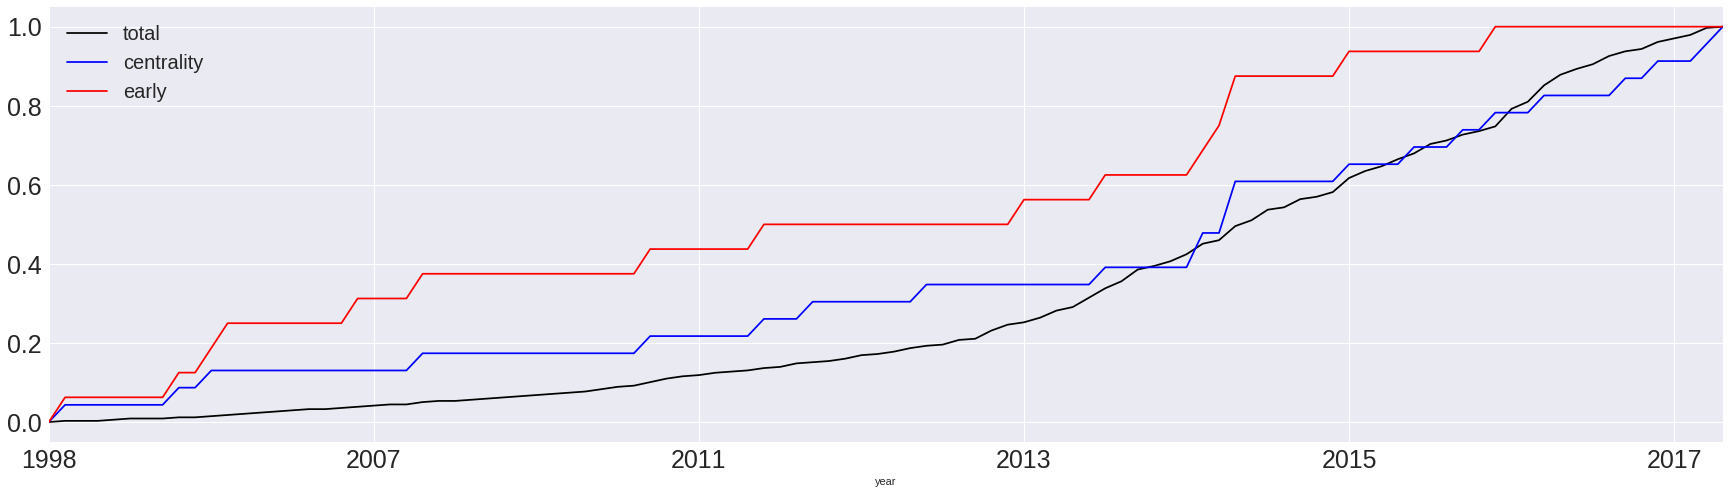

['wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wearable', 'wrist_worn', 'bluetooth_smart', 'wearable_devices', 'sensor', 'wearable_tech', 'wearable_technology']
Category: wearable
# investment by all VC 1473
# investment by top VC 171
# investment by expert VC 142


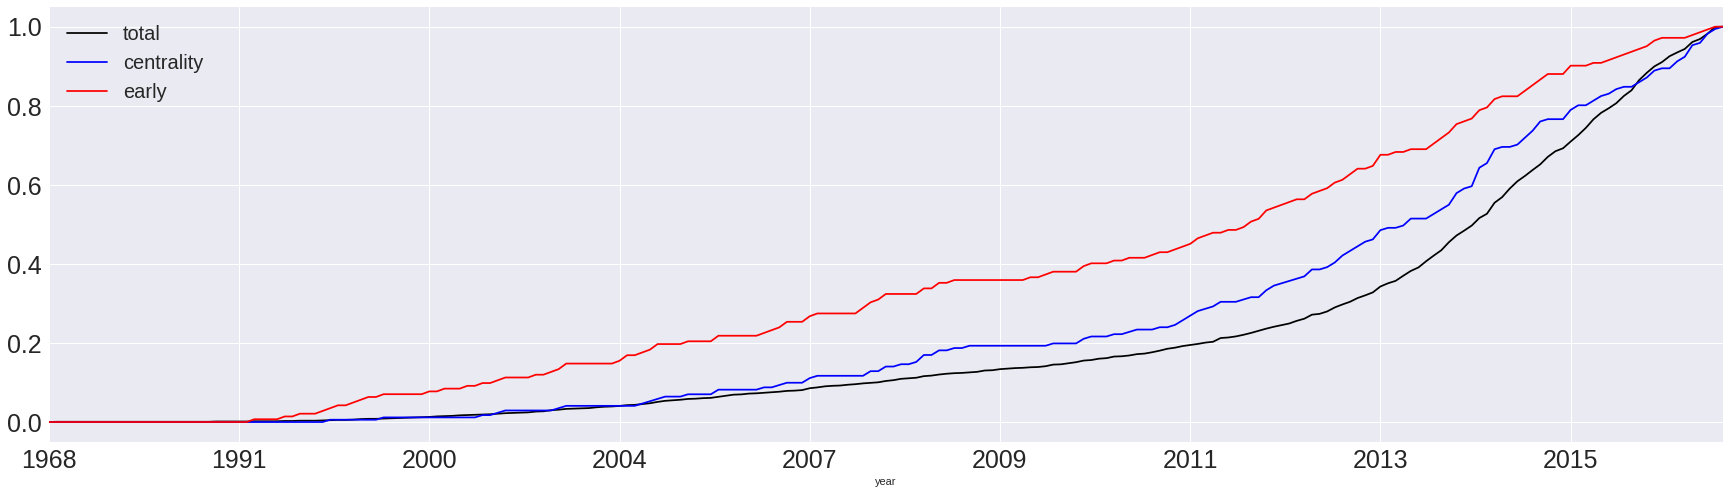

['3d_printing']
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
no data
[]
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
no data
['virtual_reality']
Category: virtual reality
# investment by all VC 310
# investment by top VC 53
# investment by expert VC 33


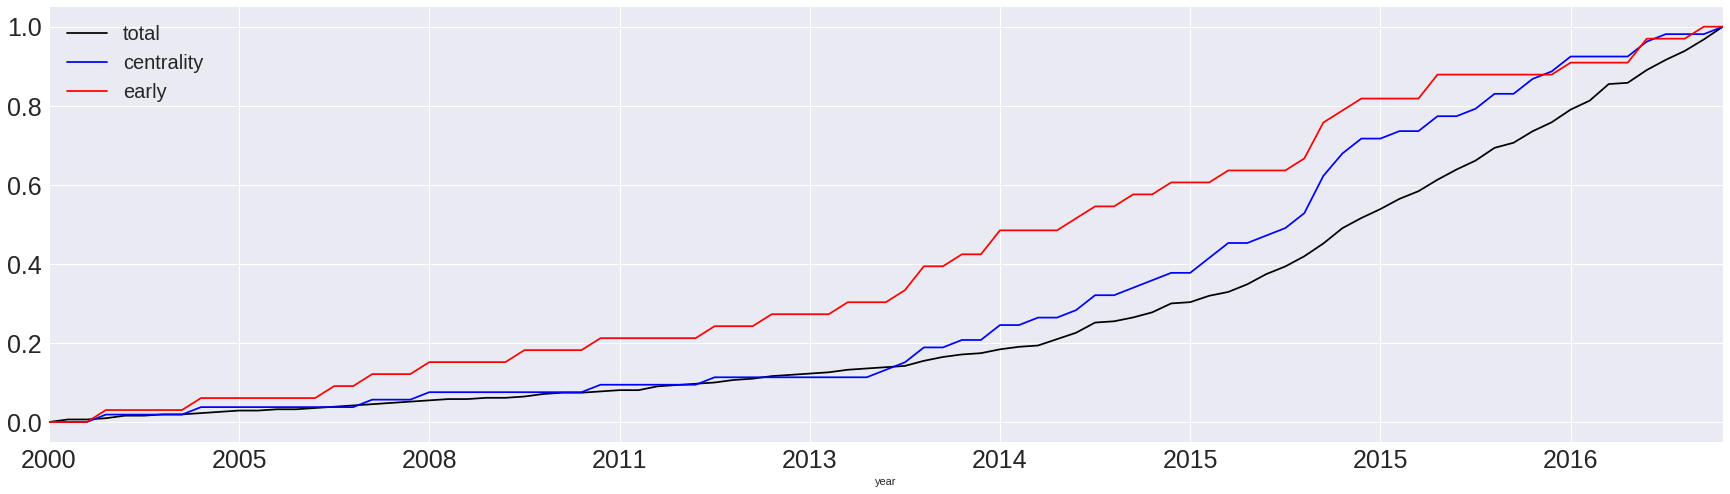

['ar_vr', 'htc_vive', 'virtual_reality', 'cinematic_vr', 'augmented_reality', 'vr_ar', 'vr', 'ar', 'immersive', 'oculus_rift', 'mixed_reality']
Category: virtual reality
# investment by all VC 981
# investment by top VC 160
# investment by expert VC 98


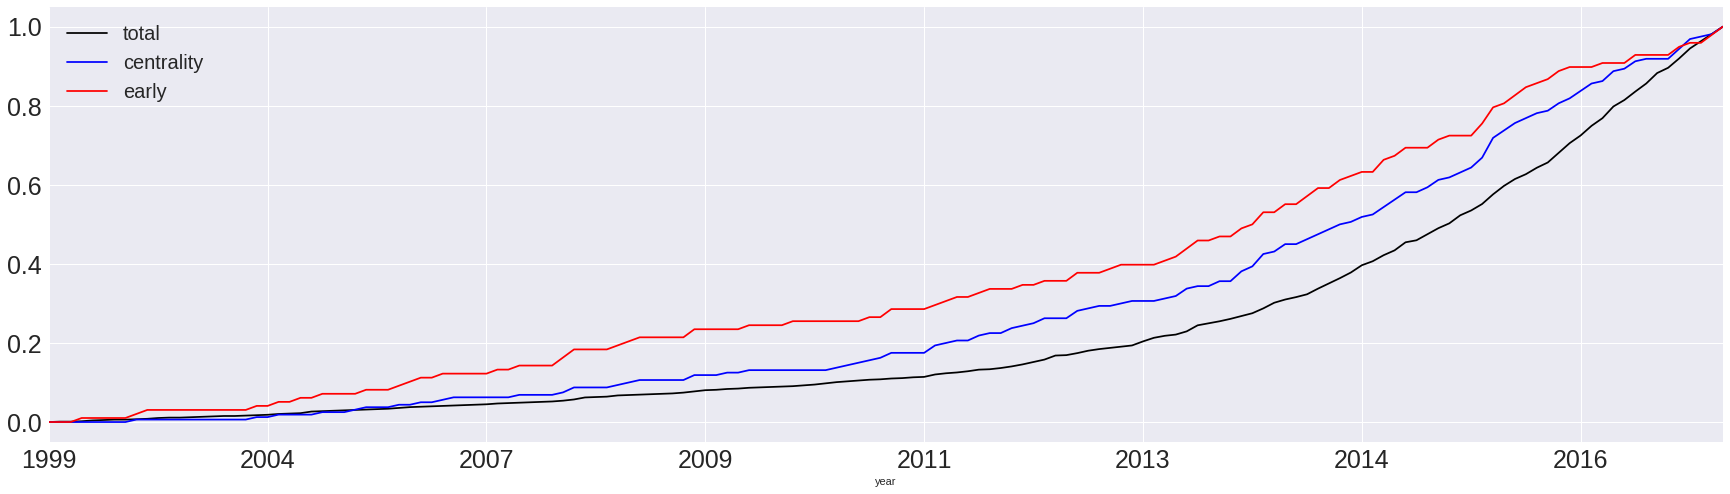

In [27]:
word_list = ['deep_learning', 'fintech', 'drone', 'wearable', '3d printing', 'virtual reality']
for word in word_list:
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = False)
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = True)